# A Study on the Robustness of CAPTCHA Recognition Models Against Various Types of Noise

**Authors:** Yann Gautier, Noé Idesheim, Titouan Constance

---

CAPTCHAs remain a standard for web security. While modern Deep Learning models (CNNs) solve them with ease on clean images, their reliability diminishes when the image is degraded.

**The central question of this project is as follows:**
> *How does image alteration via the injection of different noise types impact the resolution of CAPTCHAs by recognition models?*

We will focus on:
1.  The generation of a **synthetic CAPTCHA dataset** (based on MNIST).
2.  The training of a **Multi-Head CNN** capable of recognizing 4 digits simultaneously.
3.  The evaluation of **robustness** against two noise types (Gaussian, Salt & Pepper).

### Technical Environment
To set up the necessary environment for this project, please refer to the project's `README.md` file.

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 

# Configuration for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display Configuration
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_theme(style="whitegrid")

## 1. Data Pipeline: Construction of a CAPTCHA Dataset

Our data generation strategy relies on the assembly of handwritten digits derived from the MNIST dataset.

### Generation Process
1.  **Individual Pre-processing**: Each MNIST digit (28x28) is converted, rendering the black background transparent (Alpha channel).
2.  **Assembly & Transformations**: 4 digits are arranged side-by-side with random variations:
    * **Rotation** (slight).
    * **Scaling**.
3.  **Formatting**: The ensemble is placed on a unified black background and resized to **100x110 pixels**.

To mitigate **overfitting** (preventing the model from memorizing noisy images), noise is not stored permanently. Instead, it is injected dynamically **on-the-fly** during each training or prediction batch.

Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


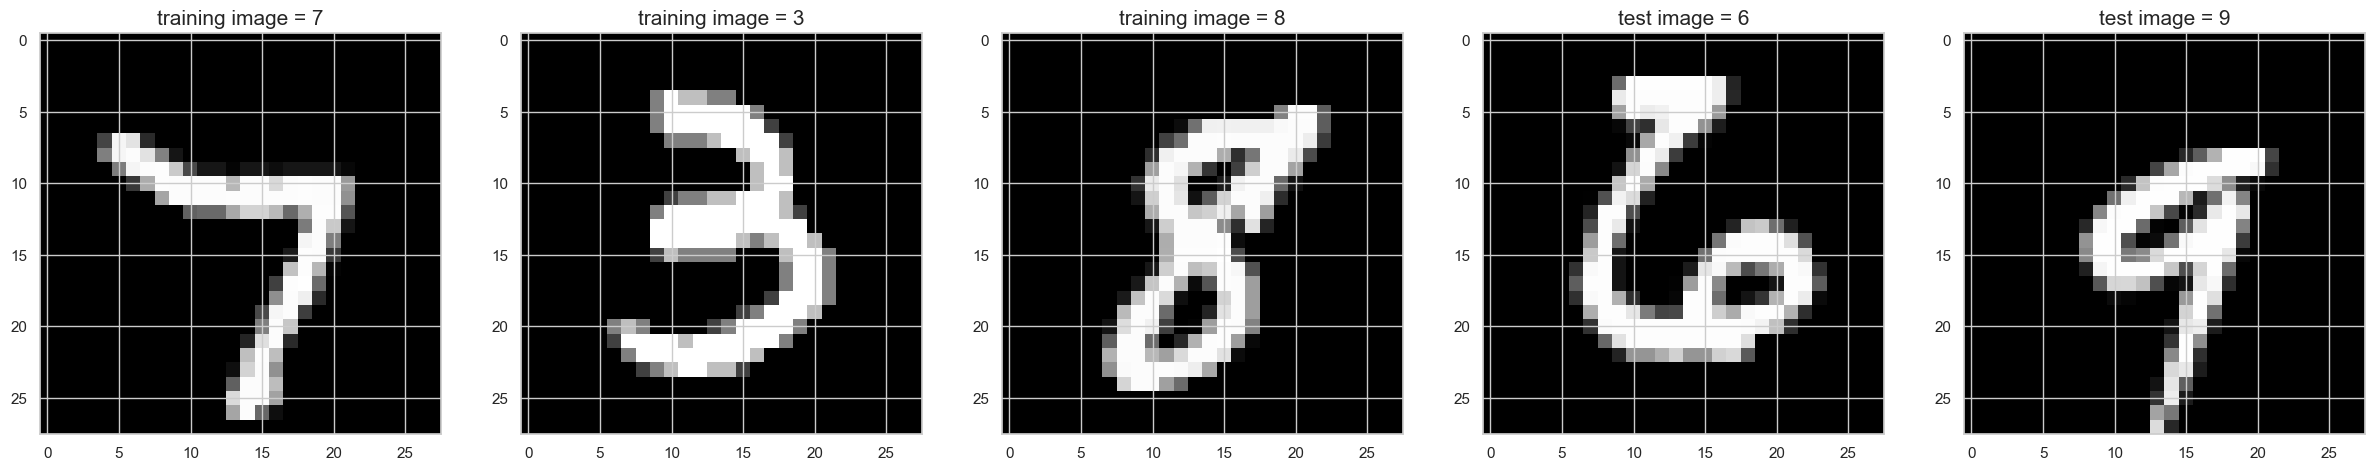

Génération Test  (20000) : 100%|██████████| 20000/20000 [00:15<00:00, 1306.85it/s]



Saving to ../data\captcha_data\captcha_dataset.h5...
CAPTCHA dataset created successfully!
Loading 3 training images (random selection)...
Loading 2 test images (random selection)...
CAPTCHA dataset loaded successfully!


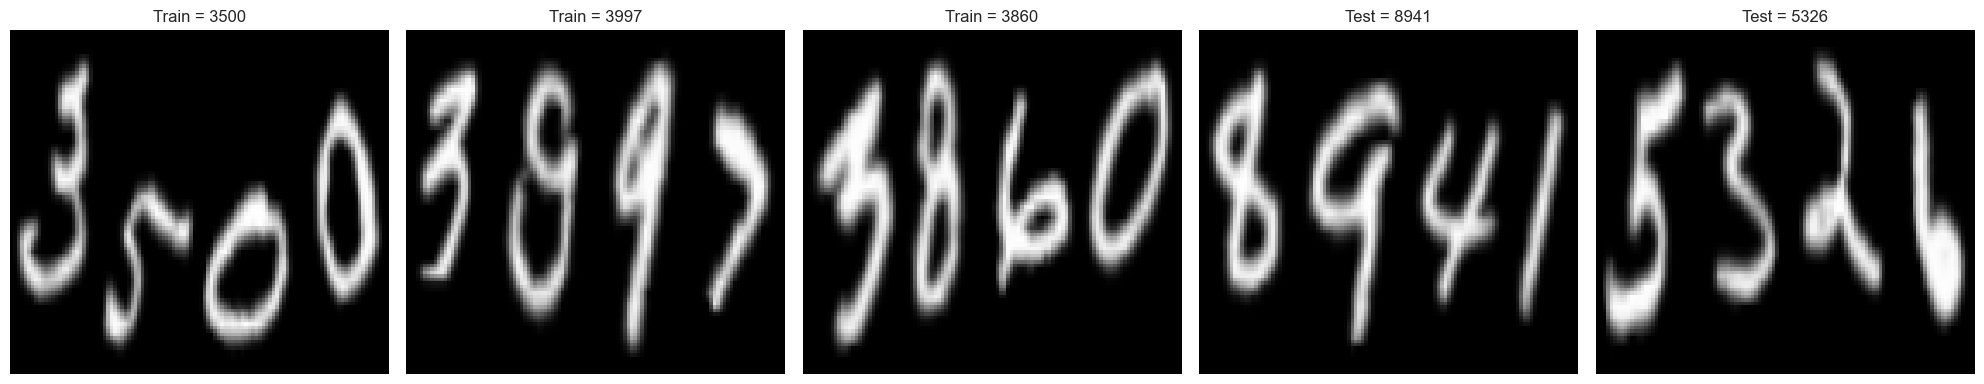

Displaying 3 training CAPTCHAs and 2 test CAPTCHAs
Loading 3 training images (random selection)...
Loading 2 test images (random selection)...
CAPTCHA dataset loaded successfully!
Applying salt_and_pepper noise (grayscale mode) to CAPTCHA images (factor: 0.1)...


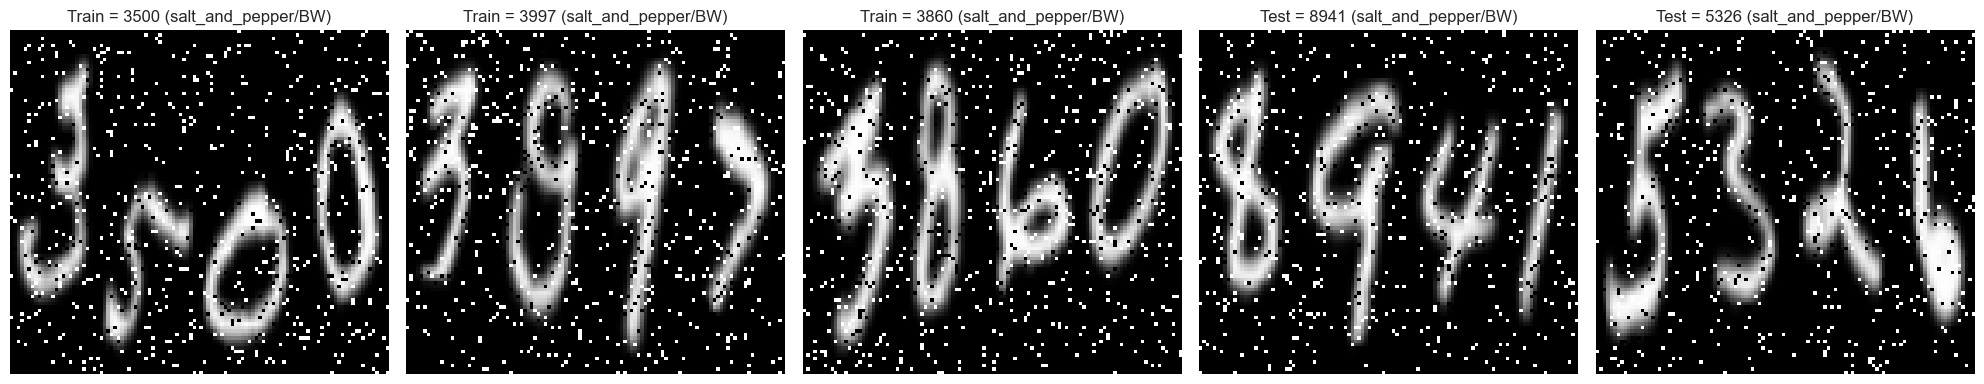

Displaying 3 training CAPTCHAs and 2 test CAPTCHAs


In [3]:
from MNIST import MnistDataloader 
import matplotlib.pyplot as plt
import numpy as np

loader = MnistDataloader(data_dir='../data')

loader.download_mnist()

loader.show_images(num_train=3, num_test=2, seed=42)

loader.create_captcha_dataset(num_train=100_000, num_test=20_000, seed=42)

loader.show_captcha(num_train=3, num_test=2, seed=42)

loader.show_captcha(num_train=3, num_test=2, apply_noise=True, noise_type='salt_and_pepper', noise_factor=0.1, seed=42)


### Technical Details on Methods Used in `MNIST.py`

For a complete understanding of the data pipeline, here is a quick summary of the key methods/functions we use in the `MnistDataloader` class (in `MNIST.py`). They are organized by role:

1. **Loading Raw Data**:
   - `download_mnist()`: Downloads the MNIST dataset from Kaggle and stores it locally.
   - `read_images_labels(images_filepath, labels_filepath, ...)`: Reads MNIST images and labels from binary files (idx3-ubyte format), with support for random or sequential image selection.
   - `load_data(...)`: Loads training and test MNIST data, with option to apply noise directly during loading.

2. **Pre-Processing and Noise Injection**:
   - `add_noise(images, noise_type, noise_factor, rgb_noise)`: Applies Gaussian or salt-and-pepper noise to images. Supports grayscale and RGB formats, with control over noise independence per channel. Noise is injected dynamically to avoid overfitting.
   - This method is generic and can be used on any set of images (MNIST or CAPTCHAs).

3. **CAPTCHA Generation**:
   - `create_sequence(mnist_images, mnist_labels, num_digits=4)`: Assembles 4 MNIST digits into a CAPTCHA, with random transformations (slight rotation, scaling). Each digit is made transparent before assembly on a black canvas, then resized to 100x110 pixels.
   - `create_captcha_dataset(num_train, num_test, ...)`: Generates a complete CAPTCHA dataset and saves it to an HDF5 (.h5) file for efficient handling of large data volumes (images and labels).

4. **Loading and Visualization**:
   - `load_captcha_dataset(h5_filepath, ...)`: Loads CAPTCHAs from the .h5 file, with options for dynamic noise.
   - `show_images(num_train, num_test, ...)`: Displays raw MNIST images, with support for applied noise.
   - `show_captcha(num_train, num_test, ...)`: Displays generated CAPTCHAs, with noise options.

These methods ensure reproducible and flexible data generation. Storage in .h5 (via HDF5) is chosen for its fast access and compression, ideal for large datasets.

Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


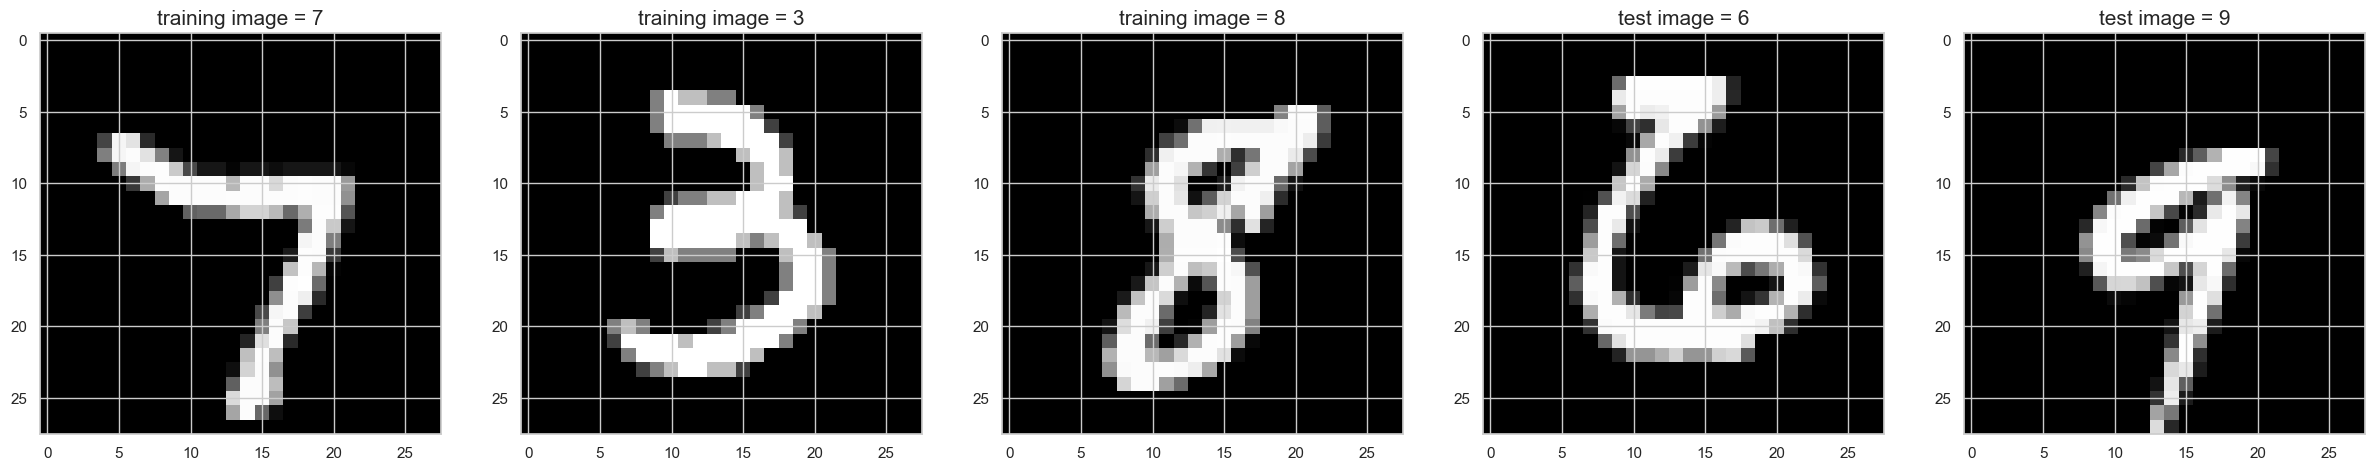


Same MNIST images with applied Gaussian noise:
Loading noisy data with (gaussian noise, factor: 0.3)...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Applying gaussian noise (factor: 0.3)...
Displaying 3 training images and 2 test images


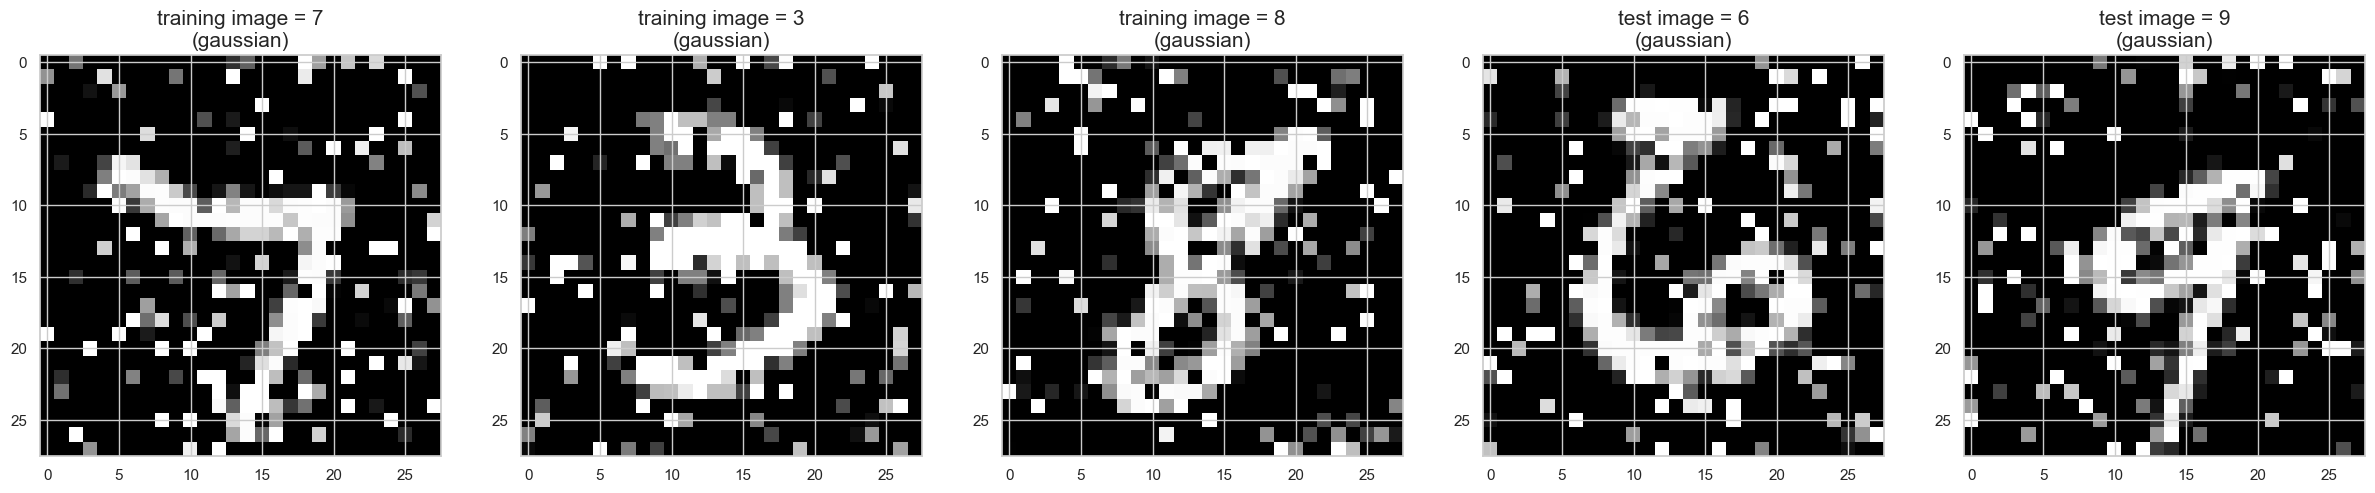

Loading all training data (100000 images)...
Loading 3 test images (sequential)...
CAPTCHA dataset loaded successfully!
Example CAPTCHA label: [7 4 0 3]


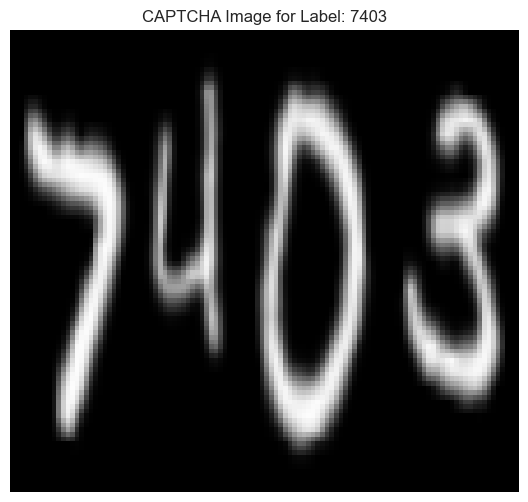

In [4]:
# Illustrative Examples of Key Methods
# 1. Loading MNIST data with applied Gaussian noise
(x_train_noisy, y_train_noisy), (x_test_noisy, y_test_noisy) = loader.load_data(
    apply_noise=True, noise_type='gaussian', noise_factor=0.3, num_images_train=5, num_images_test=3
)

# 2. Displaying MNIST images: first originals, then the same with Gaussian noise
print("Original MNIST images:")
loader.show_images(num_train=3, num_test=2, show_noisy=False, seed=42)

print("\nSame MNIST images with applied Gaussian noise:")
loader.show_images(num_train=3, num_test=2, show_noisy=True, noise_type='gaussian', noise_factor=0.3, seed=42)

# 3. Loading a CAPTCHA from .h5 and displaying it with its label
(x_train_captcha, y_train_captcha), (x_test_captcha, y_test_captcha) = loader.load_captcha_dataset(
    h5_filepath=os.path.join('..', 'data', 'captcha_data', 'captcha_dataset.h5'), num_images_test=3
)
print(f"Example CAPTCHA label: {y_test_captcha[0]}")  # Shows the label format (list of 4 digits)

# Display the corresponding CAPTCHA image
plt.imshow(x_test_captcha[0].squeeze(), cmap='gray')
plt.title(f"CAPTCHA Image for Label: {''.join(map(str, y_test_captcha[0]))}")
plt.axis('off')
plt.show()

## 2. Modeling: Multi-Head CNN Architecture

To address the problem of CAPTCHA reading, we selected a **Multi-Head CNN** (Convolutional Neural Network) architecture.

### Rationale for this Architecture
Classical methods often require slicing the image to isolate each character (segmentation) before recognition. With the introduction of noise, this segmentation becomes unreliable.
Our approach takes the **entire** image as input and features **4 independent output heads**, each learning to predict the digit at a specific position (1st, 2nd, 3rd, 4th).

### Architecture Overview
The architecture shares a common feature extraction backbone (convolutional layers) for all digits, before branching out.

![Multi-Head CNN Architecture Diagram](..\ressources\multi_head_ccn_schema.png)

In [6]:
import multi_head_CNN 
import tensorflow as tf
import os

MODEL_PATH = os.path.join('..', 'data', 'models', 'multi_output_cnn.keras')

multi_head_CNN.train_and_evaluate(
        data_dir=os.path.join('..', 'data'),
        model_save_path=MODEL_PATH,
        apply_noise=True, 
        noise_type='salt_and_pepper', 
        noise_factor=0.2, 
        noise_factor_end=0.4, 
        noise_step=0.1,
        rgb_noise=False
    )

Loading 100000 training images (sequential)...
Loading 20000 test images (sequential)...
CAPTCHA dataset loaded successfully!

Applying salt_and_pepper noise (grayscale mode) from 0.2 to 0.4 (step 0.1)
Applying salt_and_pepper noise with 3 levels: [0.2, 0.3, 0.4] to 100000 images...
Allocating output array (uint8)...
  Level 0.20: processing 33334 images (1-33334)
  Level 0.30: processing 33333 images (33335-66667)
  Level 0.40: processing 33333 images (66668-100000)
Noise application completed for 100000 images
Applying salt_and_pepper noise with 3 levels: [0.2, 0.3, 0.4] to 20000 images...
Allocating output array (uint8)...
  Level 0.20: processing 6667 images (1-6667)
  Level 0.30: processing 6667 images (6668-13334)
  Level 0.40: processing 6666 images (13335-20000)
Noise application completed for 20000 images


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 110,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 108,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 54,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 52,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 26,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 21, 24,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7680)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    983,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1 (Dense)      │ (None, 10)        │        650 │ digit1_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2 (Dense)      │ (None, 10)        │        650 │ digit2_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3 (Dense)      │ (None, 10)        │        650 │ digit3_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4 (Dense)      │ (None, 10)        │        650 │ digit4_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,074,536 (4.10 MB)

 Trainable params: 1,074,536 (4.10 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 240s 149ms/step - digit1_accuracy: 0.7947 - digit1_loss: 0.6240 - digit2_accuracy: 0.7504 - digit2_loss: 0.7522 - digit3_accuracy: 0.7549 - digit3_loss: 0.7432 - digit4_accuracy: 0.7909 - digit4_loss: 0.6325 - loss: 2.7525 - val_digit1_accuracy: 0.9011 - val_digit1_loss: 0.3096 - val_digit2_accuracy: 0.8792 - val_digit2_loss: 0.3863 - val_digit3_accuracy: 0.8839 - val_digit3_loss: 0.3590 - val_digit4_accuracy: 0.8974 - val_digit4_loss: 0.3207 - val_loss: 1.3750
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 213s 136ms/step - digit1_accuracy: 0.9179 - digit1_loss: 0.2630 - digit2_accuracy: 0.8979 - digit2_loss: 0.3262 - digit3_accuracy: 0.8967 - digit3_loss: 0.3328 - digit4_accuracy: 0.9192 - digit4_loss: 0.2596 - loss: 1.1817 - val_digit1_accuracy: 0.9305 - val_digit1_loss: 0.2195 - val_digit2_accuracy: 0.9137 - val_digit2_loss: 0.2771 - val_digit3_accuracy: 0.9175 - val_digit3_loss: 0.2622 - val_digit4_accuracy: 0.9250 - val_digit4

### Technical Details on Key Functions in `multi_head_CNN.py`

To complement the architecture overview, here is a summary of the essential functions used in `multi_head_CNN.py` for building, pre-processing, and training the multi-head CNN:

1. **Model Construction**:
   - `build_model()`: Creates the CNN architecture with a shared convolutional backbone (Conv2D layers with MaxPooling) and 4 separate dense heads for predicting each digit. Compiles the model with Adam optimizer and categorical cross-entropy loss for multi-output training.

2. **Data Pre-Processing**:
   - `preprocess_data(x_train, y_train, x_test, y_test)`: Normalizes image pixel values to [0,1] and converts the 4-digit labels into one-hot encoded arrays, preparing them for the multi-head outputs.

3. **Noise Application for Robustness**:
   - `apply_balanced_noise(images, noise_type, noise_factor, noise_factor_end, step, rgb_noise)`: Applies noise (Gaussian or salt-and-pepper) across a range of intensities (e.g., 0.3 to 1.0) with balanced distribution, ensuring the model trains on varied noise levels for better generalization.

4. **Training and Evaluation Pipeline**:
   - `train_and_evaluate(...)`: Orchestrates the full process: loads CAPTCHA data, applies noise if specified, preprocesses data, builds/trains the model, evaluates accuracy per digit, and saves the trained model.

These functions are critical for the multi-head CNN's implementation and robustness, enabling dynamic noise injection during training.

Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 110,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 98, 108,   │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 49, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 47, 52,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 23, 26,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 21, 24,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 10, 12,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 7680)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    983,168 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1_dense        │ (None, 64)        │      8,256 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2_dense        │ (None, 64)        │      8,256 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3_dense        │ (None, 64)        │      8,256 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4_dense        │ (None, 64)        │      8,256 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1 (Dense)      │ (None, 10)        │        650 │ digit1_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2 (Dense)      │ (None, 10)        │        650 │ digit2_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3 (Dense)      │ (None, 10)        │        650 │ digit3_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4 (Dense)      │ (None, 10)        │        650 │ digit4_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,074,536 (4.10 MB)

 Trainable params: 1,074,536 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

Loading all training data (100000 images)...
Loading 4 test images (sequential)...
CAPTCHA dataset loaded successfully!
Applying gaussian noise with 3 levels: [0.3, 0.45, 0.6] to 4 images...
Allocating output array (uint8)...
  Level 0.30: processing 2 images (1-2)
  Level 0.45: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)
Noise application completed for 4 images


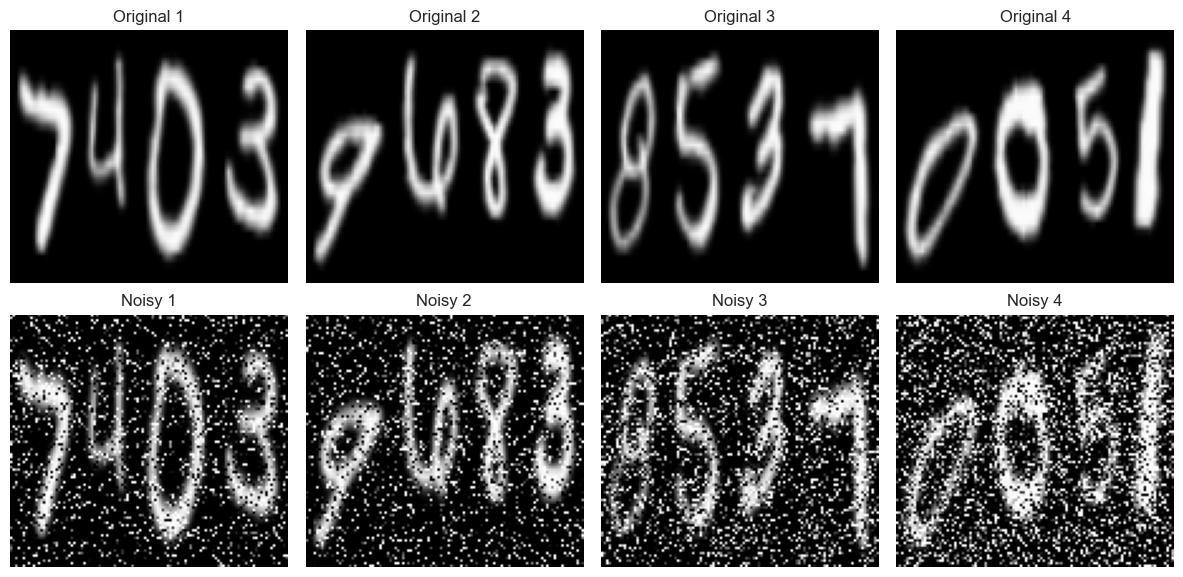

In [7]:
# Illustrative Examples of Key Functions from multi_head_CNN.py

# 1. Building the model and displaying its architecture summary
model = multi_head_CNN.build_model()
print("Model Architecture Summary:")
model.summary()

# 2. Demonstrating balanced noise application on CAPTCHA images
# Load a small set of CAPTCHA images
(x_train_captcha, _), (x_test_captcha, _) = loader.load_captcha_dataset(
    h5_filepath=os.path.join('..', 'data', 'captcha_data', 'captcha_dataset.h5'), num_images_test=4
)

# Apply balanced Gaussian noise from 0.3 to 0.6
noisy_images = multi_head_CNN.apply_balanced_noise(
    x_test_captcha, noise_type='gaussian', noise_factor=0.3, noise_factor_end=0.6, step=0.15, rgb_noise=False
)

# Visualize original vs noisy images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(x_test_captcha[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Noisy {i+1}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

## 3. Statistical Analysis and Robustness

In this section, we evaluate the robustness of our model and the OCR API against different levels and types of noise. The objectives are multiple:
- Quantify performance degradation as a function of noise.
- Compare the resilience of our specialized model to that of the general-purpose OCR API.
- Determine if combining both approaches can enhance recognition.
- Identify the CAPTCHAs that are most challenging for these models to recognize.

## 3.1. Baseline: OCR API

To benchmark the effectiveness of our specialized model, we compare it against an off-the-shelf solution: the **OCR.space** API.

> **Note**: Preliminary tests indicate that general-purpose OCR solutions (optimized for scanned documents) fail rapidly on our CAPTCHAs, even at very low (or zero) noise levels. Consequently, we restrict the noise factor here to **0.1** to maintain a feasible evaluation scope for the API.

Ensure that a `.env` file exists in the `src` directory containing your key: `OCR_api_KEY=...`.

### Technical Details on Key Functions in `OCR_api.py`

Here is a summary of the essential functions used in `OCR_api.py` for interacting with the OCR.space API:

1. **File-Based OCR Request**:
   - `ocr_space_file(filename, overlay, api_key, language, filetype, OCREngine)`: Sends a local image file to the OCR.space API for text recognition. Supports parameters like overlay, language, and OCR engine for customization.

2. **Single Image Processing and OCR**:
   - `ocr_space_one_image(image_data, api_key, language, filetype, OCREngine)`: Processes a single image in matrix format (e.g., numpy array), applies pre-processing (grayscale conversion, inversion, sharpening), saves it temporarily as a file, and sends it to the API for OCR. Returns the parsed text.

3. **Batch Testing on CAPTCHAs**:
   - `test_ocr_on_captcha(mnist_loader, api_key, h5_filepath, num_images, noise_factor, display_images)`: Generates CAPTCHAs with noise, processes each image using the API, and returns results with predictions, ground truth, and optional visualizations.

These functions handle image pre-processing and API communication, ensuring reliable OCR requests for CAPTCHA evaluation.

Loading 2 training images (sequential)...
Loading 0 test images (sequential)...
CAPTCHA dataset loaded successfully!
Applying gaussian noise (grayscale mode) to CAPTCHA images (factor: 0.1)...
Predicting image 0...


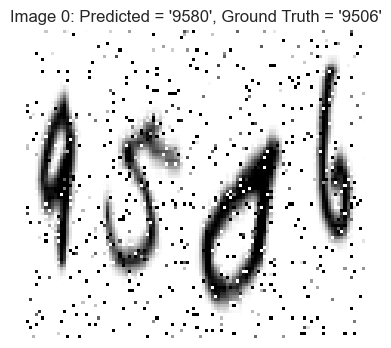

Predicting image 1...


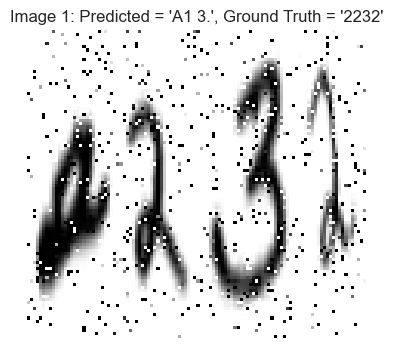


--- OCR Predictions Summary ---
Image 0: Predicted = '9580', Ground Truth = '9506'
Image 1: Predicted = 'A13.', Ground Truth = '2232'


In [8]:
import os
from dotenv import load_dotenv
from OCR_api import test_ocr_on_captcha

# Load configuration
load_dotenv(dotenv_path=os.path.join(".env")) 
api_key = os.getenv("OCR_API_KEY")

if api_key is None:
    print(" Error: API Key not found. Please verify that 'OCR_API_KEY' is present in 'src/.env'")
else:  

    h5_filepath = os.path.join('..','data', 'captcha_data', 'captcha_dataset.h5')
    
    if os.path.exists(h5_filepath):
        # OCR testing on CAPTCHAs with low noise intensity
        results = test_ocr_on_captcha(
            mnist_loader=loader,
            api_key=api_key,
            h5_filepath=h5_filepath,
            num_images=2,       # Limiting to 3 requests to avoid spamming the API
            noise_factor=0.1,   # Low noise level as the OCR is highly sensitive
            display_images=True
        )
        
        # Display text summary
        print("\n--- OCR Predictions Summary ---")
        for r in results:
            clean_pred = r['predicted'].replace(" ", "").replace("\n", "")
            print(f"Image {r['index']}: Predicted = '{clean_pred}', Ground Truth = '{r['true_label']}'")
    else:
        print(f"The file {h5_filepath} does not exist. Please execute the dataset generation (Previous Cell).")

### 3.2. Creation of an Evaluation Dataset
Initially, we will generate an evaluation dataset based on the different models by varying the type and level of noise applied to the images.

We will:
1.  Vary the noise intensity from **0.0 (clean)** to **0.5 (highly noisy)**.
2.  Test two types of noise: **Gaussian** and **Salt & Pepper**.
3.  Store these results in a **Pandas DataFrame** for analysis.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from MNIST import MnistDataloader
from multi_head_CNN import apply_balanced_noise
from multi_head_CNN import apply_balanced_noise
import os
from tqdm import tqdm

# Load CAPTCHA dataset
data_dir = '../data'
mnist_loader = MnistDataloader(data_dir=data_dir)
h5_filepath = os.path.join(data_dir, 'captcha_data', 'captcha_dataset.h5')
(x_train, y_train), (x_test, y_test) = mnist_loader.load_captcha_dataset(h5_filepath=h5_filepath, num_images_train=0, num_images_test=2000)

# Load the model
model_path = os.path.join(data_dir, 'models', 'multi_output_cnn.keras')
model = tf.keras.models.load_model(model_path)

# Configuration
NOISE_START = 0.1
NOISE_END = 1.0
NOISE_STEP = 0.1
BATCH_SIZE = 256

num_images = len(x_test)
print(f"Processing {num_images} images...")

# Convert to grayscale if needed (model expects 1 channel)
if x_test.shape[-1] == 3:
    print("Converting RGB images to grayscale...")
    x_test_gray = np.mean(x_test, axis=-1, keepdims=True).astype(np.uint8)
else:
    x_test_gray = x_test

# Preprocess all images once (normalize)
x_test_normalized = x_test_gray.astype('float32') / 255.0

# ============ STEP 1: Predict on clean images (batch) ============
print("\n=== Step 1: Predicting on clean images ===")
predictions_clean = model.predict(x_test_normalized, batch_size=BATCH_SIZE, verbose=1)
# predictions_clean is a list of 4 arrays (one per digit head)
predicted_clean = np.argmax(predictions_clean, axis=-1).T  # Shape: (num_images, 4)

# Build clean data rows
data_rows = []
for idx in range(num_images):
    solution = ''.join(map(str, y_test[idx]))
    response = ''.join(map(str, predicted_clean[idx]))
    data_rows.append({
        'id': idx,
        'image_format': 0,  # Grayscale
        'image_data': x_test_gray[idx].astype(int),
        'solution': solution,
        'noise': 0,
        'noise_type': 'none',
        'noise_factor': 0.0,
        'model_response': response
    })
print(f"Added {num_images} clean predictions")

# ============ STEP 2: Process noisy images for each noise type ============
for noise_type in ['gaussian', 'salt_and_pepper']:
    print(f"\n=== Processing {noise_type} noise ===")
    
    # Apply ALL noise levels to ALL images using the new parameter
    noisy_images, noise_levels = apply_balanced_noise(
        x_test_gray, 
        noise_type=noise_type, 
        noise_factor=NOISE_START, 
        noise_factor_end=NOISE_END, 
        step=NOISE_STEP,
        rgb_noise=False,
        apply_all_levels=True  
    )
    
    # Normalize for model prediction
    noisy_images_normalized = noisy_images.astype('float32') / 255.0
    
    # Predict in batch on all noisy images at once
    print(f"Predicting on {len(noisy_images)} noisy images...")
    predictions_noisy = model.predict(noisy_images_normalized, batch_size=BATCH_SIZE, verbose=1)
    predicted_noisy = np.argmax(predictions_noisy, axis=-1).T  # Shape: (num_images * num_levels, 4)
    
    # Build data rows for noisy predictions
    # Structure: for each level, images 0 to num_images-1 are at indices level_idx * num_images to (level_idx+1) * num_images - 1
    for level_idx, level in enumerate(noise_levels):
        start_idx = level_idx * num_images
        for img_idx in range(num_images):
            global_idx = start_idx + img_idx
            solution = ''.join(map(str, y_test[img_idx]))
            response = ''.join(map(str, predicted_noisy[global_idx]))
            data_rows.append({
                'id': img_idx,
                'image_format': 0,
                'image_data': x_test_gray[img_idx].astype(int),
                'solution': solution,
                'noise': 1,
                'noise_type': noise_type,
                'noise_factor': level,
                'model_response': response
            })
    
    print(f"Added {len(noise_levels) * num_images} predictions for {noise_type}")
    
    # Free memory
    del noisy_images, noisy_images_normalized, predictions_noisy, predicted_noisy

# ============ STEP 3: Create and save DataFrame ============
print("\n=== Step 3: Creating DataFrame ===")
df = pd.DataFrame(data_rows)
print(f"Total rows: {len(df)}")
print(f"Unique images: {df['id'].nunique()}")
print(f"Noise types: {df['noise_type'].unique()}")
print(f"Noise levels: {sorted(df['noise_factor'].unique())}")

# Save to pickle
path_to_save = '../data/captcha_evaluation.pkl'
df.to_pickle(path_to_save)
print("\nPickle file 'captcha_evaluation.pkl' created successfully.")

Loading 0 training images (sequential)...
Loading 2000 test images (sequential)...
CAPTCHA dataset loaded successfully!
Processing 2000 images...
Converting RGB images to grayscale...

=== Step 1: Predicting on clean images ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Added 2000 clean predictions

=== Processing gaussian noise ===
Applying gaussian noise: ALL 10 levels to ALL 2000 images...
  Noise levels: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Output will have 20000 images
  Level 0.10: indices 0-1999
  Level 0.20: indices 2000-3999
  Level 0.30: indices 4000-5999
  Level 0.40: indices 6000-7999
  Level 0.50: indices 8000-9999
  Level 0.60: indices 10000-11999
  Level 0.70: indices 12000-13999
  Level 0.80: indices 14000-15999
  Level 0.90: indices 16000-17999
  Level 1.00: indices 18000-19999
Noise application completed: 20000 noisy images
Predicting on 20000 noisy images...
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step
Added 20000 predictions for gaussian

=== Processing salt

In [ ]:
#if necessary reload dataset from pickle 
# import pandas as pd 
# path_to_save = '../data/captcha_evaluation.pkl'
# df = pd.read_pickle(path_to_save)

In [6]:
#We add some prediction of OCR API
import random
from OCR_api import ocr_space_one_image
from dotenv import load_dotenv
df["OCR_response"] = np.nan

indexes = random.sample(range(df["id"].max()), k=10)  # Select 10 random indexes for OCR predictions
print(indexes)

load_dotenv(dotenv_path=".env") 
api_key = os.getenv("OCR_API_KEY")
for idx in indexes:
    image_data = df[df["id"]==idx]["image_data"].values[0]
    text=ocr_space_one_image(image_data=image_data, api_key=api_key)
    df.loc[df["id"]==idx, "OCR_response"] = text

[1309, 228, 51, 1518, 563, 501, 457, 285, 1508, 209]
Predicting image...


C:\Users\admin\AppData\Local\Temp\ipykernel_17116\781620194.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51ll' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["id"]==idx, "OCR_response"] = text


Predicting image...
Predicting image...
Predicting image...
Predicting image...
Predicting image...
Predicting image...
Predicting image...
Predicting image...
Predicting image...


In [7]:
df['correct'] = df.apply(
    lambda row: int(all(a == b for a, b in zip(row['solution'], row['model_response']))),
    axis=1
)
# Compute the number of correct digits for each prediction
df['n_correct_digits'] = df.apply(
    lambda row: sum(1 for a, b in zip(row['solution'], row['model_response']) if a == b), 
    axis=1
)

# Evaluate each digit independently
for digit_pos in range(4):
    df[f'correct_digit_{digit_pos}'] = df.apply(
        lambda row: int(row['solution'][digit_pos] == row['model_response'][digit_pos]),
        axis=1
    )

## 3.3. Global Performance Analysis of the CNN Model

In this section, we analyze the overall performance of our multi-head CNN model using the evaluation dataset created in section 3.2. We focus on descriptive statistics to assess robustness against noise, without retraining or re-evaluating the model. Key metrics include:

- **Global Accuracy**: Percentage of CAPTCHAs where all 4 digits are correctly predicted.
- **Average Accuracy per Digit**: Mean accuracy across the 4 positions, highlighting potential weaknesses in specific digits.
- **Performance by Noise Level**: Trends in accuracy as noise intensity increases (from 0.0 to 1.0).
- **Comparison by Noise Type**: Differences between Gaussian and Salt & Pepper noise.

We leverage the existing DataFrame (`df`) for these analyses, grouping data by noise factors and types.

=== Global Performance Statistics ===
Total CAPTCHAs evaluated: 42000
Global Accuracy (all 4 digits correct): 50.87%
Average Correct Digits per CAPTCHA: 2.96/4
Accuracy for Digit 1: 75.79%
Accuracy for Digit 2: 71.44%
Accuracy for Digit 3: 73.17%
Accuracy for Digit 4: 75.16%


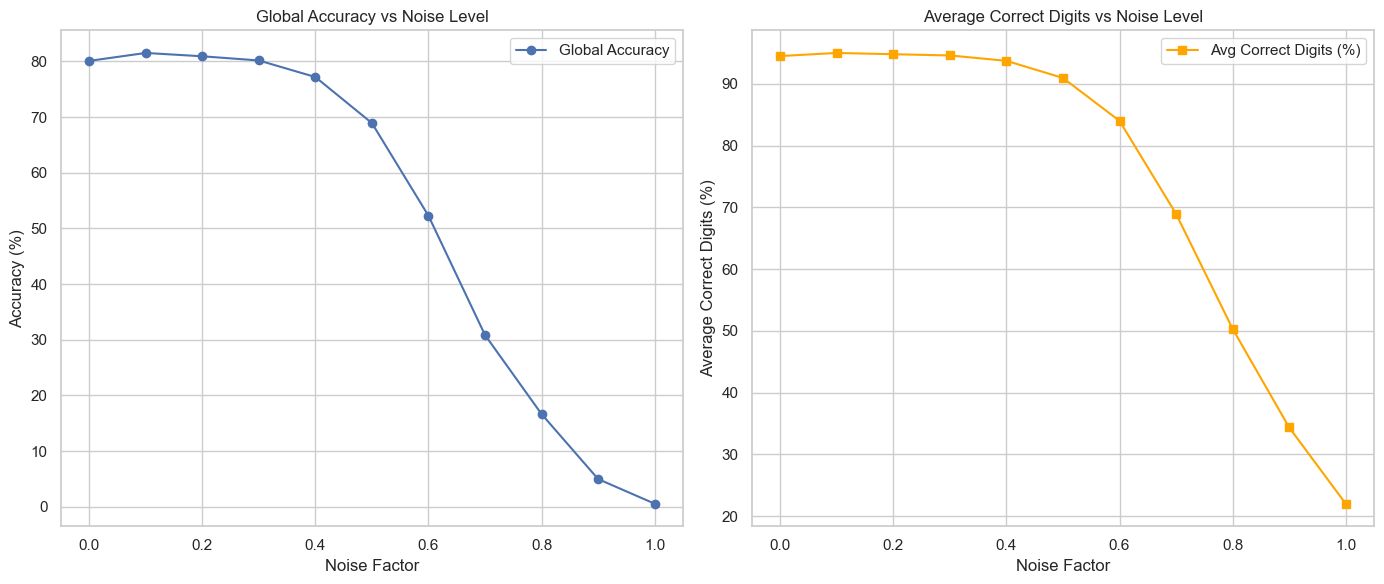

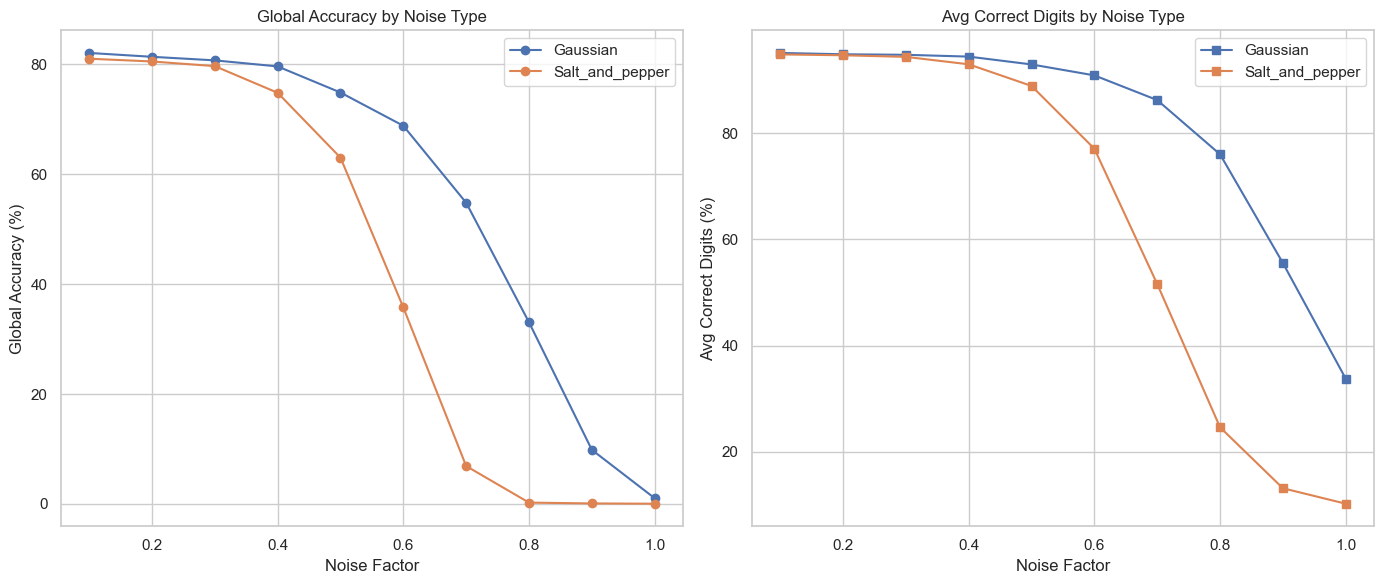

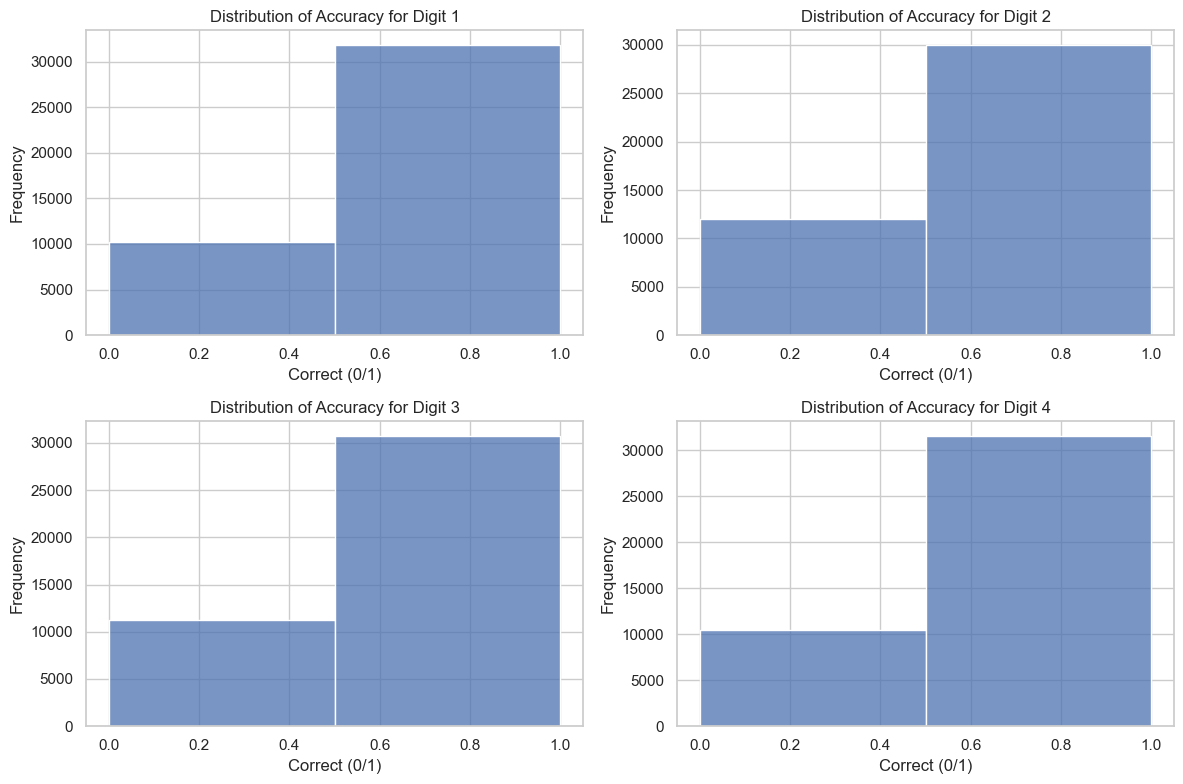


=== Summary by Noise Type ===
                 correct_mean  correct_std  n_correct_digits_mean  \
noise_type                                                          
gaussian                56.61    49.562392                325.885   
none                    80.10    39.934789                377.950   
salt_and_pepper         42.20    49.389088                257.015   

                 n_correct_digits_std  
noise_type                             
gaussian                   103.440813  
none                        46.474482  
salt_and_pepper            152.141208  

=== T-Tests for Significance ===
T-test for Global Accuracy (Gaussian vs Salt & Pepper): t = 29.125, p = 0.000
T-test for Avg Correct Digits (Gaussian vs Salt & Pepper): t = 52.940, p = 0.000
T-test at Noise Factor 0.3 (Global Accuracy): t = 0.833, p = 0.405
T-test at Noise Factor 0.6 (Global Accuracy): t = 22.167, p = 0.000
T-test at Noise Factor 0.9 (Global Accuracy): t = 14.547, p = 0.000


In [8]:
# df should already be in memory; otherwise, reload from CSV
# df = pd.read_csv('data/captcha_evaluation.csv')  # Uncomment if necessary

# 1. Global descriptive statistics
print("=== Global Performance Statistics ===")
total_captchas = len(df)
global_accuracy = df['correct'].mean() * 100  # Percentage of CAPTCHAs with all 4 digits correct
avg_correct_digits = df['n_correct_digits'].mean()  # Average correct digits per CAPTCHA
print(f"Total CAPTCHAs evaluated: {total_captchas}")
print(f"Global Accuracy (all 4 digits correct): {global_accuracy:.2f}%")
print(f"Average Correct Digits per CAPTCHA: {avg_correct_digits:.2f}/4")

# Accuracy per digit (average across all noise levels)
digit_accuracies = []
for i in range(4):
    acc = df[f'correct_digit_{i}'].mean() * 100
    digit_accuracies.append(acc)
    print(f"Accuracy for Digit {i+1}: {acc:.2f}%")

# 2. Performance by noise level (grouping by noise_factor)
noise_performance = df.groupby('noise_factor').agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
noise_performance['correct'] *= 100  # Convert to %
noise_performance['n_correct_digits'] /= 4  # Normalize to [0,1] for consistency

# Visualization: Accuracy vs Noise Level
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Global accuracy (all digits correct)
ax[0].plot(noise_performance['noise_factor'], noise_performance['correct'], marker='o', label='Global Accuracy')
ax[0].set_xlabel('Noise Factor')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Global Accuracy vs Noise Level')
ax[0].grid(True)
ax[0].legend()

# Subplot 2: Average accuracy per digit
ax[1].plot(noise_performance['noise_factor'], noise_performance['n_correct_digits'] * 100, marker='s', color='orange', label='Avg Correct Digits (%)')
ax[1].set_xlabel('Noise Factor')
ax[1].set_ylabel('Average Correct Digits (%)')
ax[1].set_title('Average Correct Digits vs Noise Level')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

# 3. Comparison by noise type (Gaussian vs Salt & Pepper)
noise_type_performance = df[df['noise'] == 1].groupby(['noise_type', 'noise_factor']).agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
noise_type_performance['correct'] *= 100
noise_type_performance['n_correct_digits'] /= 4

# Visualization: Comparison of noise types
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for noise_type in ['gaussian', 'salt_and_pepper']:
    subset = noise_type_performance[noise_type_performance['noise_type'] == noise_type]
    ax[0].plot(subset['noise_factor'], subset['correct'], marker='o', label=f'{noise_type.capitalize()}')
    ax[1].plot(subset['noise_factor'], subset['n_correct_digits'] * 100, marker='s', label=f'{noise_type.capitalize()}')

ax[0].set_xlabel('Noise Factor')
ax[0].set_ylabel('Global Accuracy (%)')
ax[0].set_title('Global Accuracy by Noise Type')
ax[0].legend()
ax[0].grid(True)

ax[1].set_xlabel('Noise Factor')
ax[1].set_ylabel('Avg Correct Digits (%)')
ax[1].set_title('Avg Correct Digits by Noise Type')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 4. Distribution of performances (histogram of accuracies per digit)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    sns.histplot(df[f'correct_digit_{i}'], bins=2, ax=axes[i//2, i%2], kde=False)
    axes[i//2, i%2].set_title(f'Distribution of Accuracy for Digit {i+1}')
    axes[i//2, i%2].set_xlabel('Correct (0/1)')
    axes[i//2, i%2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Statistical summary by noise type
print("\n=== Summary by Noise Type ===")
summary = df.groupby('noise_type').agg({
    'correct': ['mean', 'std'],
    'n_correct_digits': ['mean', 'std']
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary *= 100  # Convert to %
print(summary)

# Additional t-tests for significance
from scipy.stats import ttest_ind

print("\n=== T-Tests for Significance ===")

# T-test between Gaussian and Salt & Pepper for global accuracy
gaussian_correct = df[df['noise_type'] == 'gaussian']['correct'] * 100
salt_pepper_correct = df[df['noise_type'] == 'salt_and_pepper']['correct'] * 100
t_stat_correct, p_val_correct = ttest_ind(gaussian_correct, salt_pepper_correct)
print(f"T-test for Global Accuracy (Gaussian vs Salt & Pepper): t = {t_stat_correct:.3f}, p = {p_val_correct:.3f}")

# T-test for average correct digits
gaussian_digits = df[df['noise_type'] == 'gaussian']['n_correct_digits'] * 100 / 4  # Normalize back
salt_pepper_digits = df[df['noise_type'] == 'salt_and_pepper']['n_correct_digits'] * 100 / 4
t_stat_digits, p_val_digits = ttest_ind(gaussian_digits, salt_pepper_digits)
print(f"T-test for Avg Correct Digits (Gaussian vs Salt & Pepper): t = {t_stat_digits:.3f}, p = {p_val_digits:.3f}")

# T-test for each noise level (e.g., at noise_factor=0.3)
for nf in [0.3, 0.6, 0.9]:
    gauss_nf = df[(df['noise_type'] == 'gaussian') & (df['noise_factor'] == nf)]['correct'] * 100
    sp_nf = df[(df['noise_type'] == 'salt_and_pepper') & (df['noise_factor'] == nf)]['correct'] * 100
    if len(gauss_nf) > 0 and len(sp_nf) > 0:
        t_stat_nf, p_val_nf = ttest_ind(gauss_nf, sp_nf)
        print(f"T-test at Noise Factor {nf} (Global Accuracy): t = {t_stat_nf:.3f}, p = {p_val_nf:.3f}")

**Precision, Recall, and F1-Score per Digit Position**

To complement the CNN model's performance analysis, we compute additional metrics: precision (proportion of correct predictions among all predictions made), recall (proportion of true positives among all actual positives), and F1-score (harmonic mean of precision and recall). These metrics are calculated for each digit position (1 to 4) by treating the task as a multi-class classification (digits 0-9). We use the macro average to balance the classes, avoiding biases from less frequent digits. This allows for a finer evaluation of the model's errors beyond simple accuracy.

In [9]:
from sklearn.metrics import classification_report

# Calculation of precision, recall, and F1-score per digit position
print("\n=== Precision, Recall, and F1-Score per Digit Position ===")
for i in range(4):
    y_true = df['solution'].str[i].astype(int)
    y_pred = df['model_response'].str[i].astype(int)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    print(f"Position {i+1}:")
    print(f"  Precision (macro): {report['macro avg']['precision']:.3f}")
    print(f"  Recall (macro): {report['macro avg']['recall']:.3f}")
    print(f"  F1-Score (macro): {report['macro avg']['f1-score']:.3f}")
    print()


=== Precision, Recall, and F1-Score per Digit Position ===
Position 1:
  Precision (macro): 0.777
  Recall (macro): 0.760
  F1-Score (macro): 0.761

Position 2:
  Precision (macro): 0.762
  Recall (macro): 0.716
  F1-Score (macro): 0.720

Position 3:
  Precision (macro): 0.763
  Recall (macro): 0.732
  F1-Score (macro): 0.738

Position 4:
  Precision (macro): 0.770
  Recall (macro): 0.751
  F1-Score (macro): 0.754



To analyze the overall performance of our multi-head CNN model, we leverage the `evaluate_model.py` script, which provides statistical evaluation tools for pre-trained models. This approach focuses on descriptive statistics and robustness testing against noise, using already trained models without retraining. Key functions include noise-level evaluations and performance metrics.

As an example, we demonstrate the `evaluate_captcha_vs_noise` function, which assesses model accuracy across a range of noise intensities (e.g., Salt & Pepper noise from 0.0 to 0.5). This generates plots showing per-digit and average accuracies, highlighting degradation patterns.

Loading model from ../data/models/multi_output_cnn.keras...
Loading CAPTCHA test dataset...
Loading 0 training images (sequential)...
Loading all test data (20000 images)...
CAPTCHA dataset loaded successfully!
Evaluating model from noise in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]...


Evaluating noise levels: 100%|██████████| 21/21 [13:35<00:00, 38.82s/it]


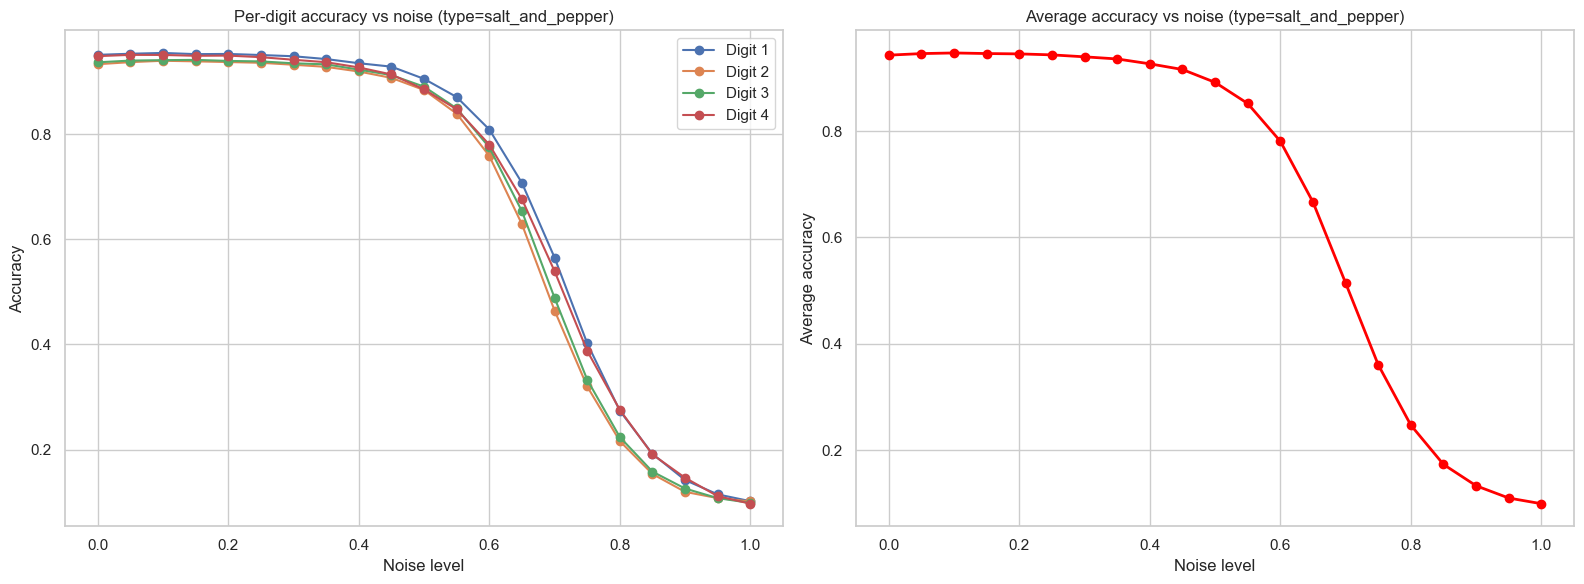

(<Figure size 1600x600 with 2 Axes>,
 [0.0,
  0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,
  1.0],
 array([[0.95139998, 0.93355   , 0.93720001, 0.94889998],
        [0.95349997, 0.9375    , 0.94045001, 0.95134997],
        [0.95499998, 0.94015002, 0.94129997, 0.95120001],
        [0.95275003, 0.93900001, 0.9418    , 0.94959998],
        [0.95310003, 0.93769997, 0.93980002, 0.94994998],
        [0.95104998, 0.93624997, 0.93889999, 0.94700003],
        [0.94870001, 0.93255001, 0.93529999, 0.94199997],
        [0.94335002, 0.9285    , 0.93330002, 0.93734998],
        [0.93545002, 0.91970003, 0.92325002, 0.92745   ],
        [0.9289    , 0.90750003, 0.91275001, 0.91404998],
        [0.90565002, 0.88445002, 0.8908    , 0.88559997],
        [0.87105   , 0.83939999, 0.84939998, 0.8477    ],
        [0.80925   , 0.75889999, 0.77509999, 0.78044999],
        [0.70754999, 0.62879997, 0.65355003, 0.6765

In [33]:
from evaluate_model import evaluate_captcha_vs_noise

# Example: Evaluate the CAPTCHA model against Salt & Pepper noise
# It evaluates the pre-trained multi-head CNN on varying noise levels and plots results
evaluate_captcha_vs_noise(
    model_path='../data/models/multi_output_cnn.keras',  # Path to the saved model
    data_dir='../data',  # Directory containing CAPTCHA data folder
    noise_type='salt_and_pepper',  # Type of noise to apply
    noise_factor_start=0.0,  # Starting noise level
    noise_factor_end=1.0,  # Ending noise level
    noise_step=0.05,  # Step size for noise levels
    rgb_noise=False,  # Apply noise in grayscale
    sample_size=None  # Use all test data for accurate results
)

To rigorously analyze the impact of noise on the CNN model's performance, we perform a logistic regression explaining the prediction success (`correct`: 1 if all 4 digits are correct, 0 otherwise) as a function of:
- **Noise factor** (`noise_factor`): Continuous level of noise (0.0 to 1.0).
- **Presence of noise** (`noise`): Binary indicator (0 = no noise, 1 = noise present).
- **Noise type** (`noise_type`): Categorical (gaussian, salt_and_pepper, none), encoded as dummies.

**Econometric Rigor Applied**:
- **Model Specification**: Logit (logistic regression) with robust standard errors clustered by `id` (CAPTCHA group) to account for intra-group correlation.
- **Variable Encoding**: Dummies for `noise_type` (reference: 'none').
- **Multicollinearity Check**: Correlation matrix and VIF for regressors.
- **Higher-Order Terms**: Test for quadratic (order 2) and cubic (order 3) terms on `noise_factor` using likelihood ratio tests.
- **Validation**: Leave-one-out cross-validation (LOOCV) for out-of-sample accuracy and AUC (ROC).
- **Diagnostics**: Hosmer-Lemeshow test for goodness-of-fit; check for perfect separation.
- **Outputs**: Regression table (log-odds coefficients, odds ratios, p-values, z-stats), pseudo-R² (McFadden), likelihood ratio test. Scatter plots with logistic curves for each regressor.
- **Interpretation**: Odds ratios >1 indicate increased odds of success; focus on probabilistic predictions.

This analysis uses the evaluation DataFrame (`df`) from section 3.2.

=== Econometric Analysis: Logistic Regression ===

1. Correlation Matrix of Regressors:
                            const  noise_factor     noise  \
const                         NaN           NaN       NaN   
noise_factor                  NaN      1.000000  0.385550   
noise                         NaN      0.385550  1.000000   
noise_type_salt_and_pepper    NaN      0.082199  0.213201   
noise_type_gaussian           NaN      0.082199  0.213201   

                            noise_type_salt_and_pepper  noise_type_gaussian  
const                                              NaN                  NaN  
noise_factor                                  0.082199             0.082199  
noise                                         0.213201             0.213201  
noise_type_salt_and_pepper                    1.000000            -0.909091  
noise_type_gaussian                          -0.909091             1.000000  

Variance Inflation Factors (VIF):
  noise_factor: 1.17
  noise: inf
  noise_

c:\Users\admin\OneDrive - GENES\ENSAE\Python-Data-2A-ENSAE\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\admin\OneDrive - GENES\ENSAE\Python-Data-2A-ENSAE\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



3. Regression Results:
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                42000
Model:                          Logit   Df Residuals:                    41993
Method:                           MLE   Df Model:                            6
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                  0.3552
Time:                        20:23:37   Log-Likelihood:                -18769.
converged:                       True   LL-Null:                       -29106.
Covariance Type:              cluster   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.3926      0.056     24.855      0.000       1.283       1.502
noise_factor                   2.7195      0.676      4.022

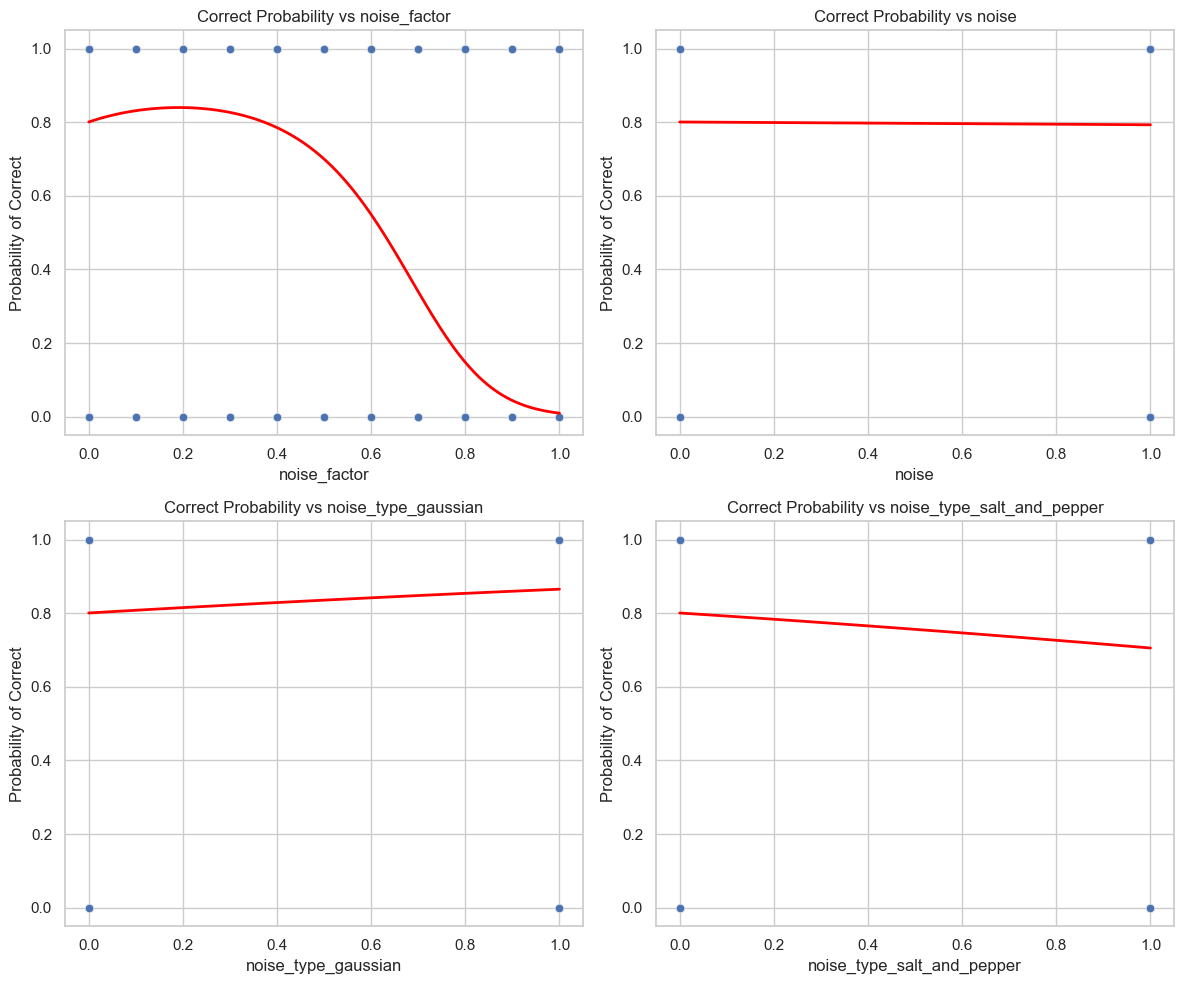

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as oi
from statsmodels.discrete.discrete_model import Logit
from scipy.stats import chi2
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare data: Filter to relevant columns and handle missing values
df_reg = df[['correct', 'noise_factor', 'noise', 'noise_type']].dropna()

# Encode noise_type as dummies 
df_reg = pd.get_dummies(df_reg, columns=['noise_type'], drop_first=False, dtype=int) 

# Define dependent and independent variables
y = df_reg['correct']
X = df_reg[['noise_factor', 'noise', 'noise_type_salt_and_pepper', 'noise_type_gaussian']]

# Add constant for logit
X = sm.add_constant(X)

print("=== Econometric Analysis: Logistic Regression ===\n")

# 1. Check correlations and multicollinearity
print("1. Correlation Matrix of Regressors:")
corr_matrix = X.corr()
print(corr_matrix)
print("\nVariance Inflation Factors (VIF):")
for i, col in enumerate(X.columns):
    if col != 'const':
        vif = oi.variance_inflation_factor(X.values, i)
        print(f"  {col}: {vif:.2f}")

# 2. Test for higher-order terms on noise_factor using likelihood ratio tests
print("\n2. Testing Higher-Order Terms for noise_factor:")
# Baseline model
model_base = Logit(y, X).fit(disp=False)
ll_base = model_base.llf
# Quadratic
X_quad = X.copy()
X_quad['noise_factor_sq'] = X_quad['noise_factor'] ** 2
model_quad = Logit(y, X_quad).fit(disp=False)
ll_quad = model_quad.llf
lr_stat_quad = 2 * (ll_quad - ll_base)
p_quad = chi2.sf(lr_stat_quad, 1)  # df=1 for added term
print(f"  Quadratic term: LR stat = {lr_stat_quad:.3f}, p-value = {p_quad:.3f}")
# Cubic
X_cubic = X_quad.copy()
X_cubic['noise_factor_cu'] = X_cubic['noise_factor'] ** 3
model_cubic = Logit(y, X_cubic).fit(disp=False)
ll_cubic = model_cubic.llf
lr_stat_cubic = 2 * (ll_cubic - ll_quad)
p_cubic = chi2.sf(lr_stat_cubic, 1)
print(f"  Cubic term: LR stat = {lr_stat_cubic:.3f}, p-value = {p_cubic:.3f}")
# Decision: Include if p < 0.05
include_quad = p_quad < 0.05
include_cubic = p_cubic < 0.05
if include_quad:
    X = X_quad
    print("  -> Quadratic term included.")
if include_cubic:
    X = X_cubic
    print("  -> Cubic term included.")

# 3. Fit the logit model with clustered standard errors
model = Logit(y, X).fit(cov_type='cluster', cov_kwds={'groups': df_reg.index}, disp=False)
print("\n3. Regression Results:")
print(model.summary())
# Odds ratios
print("\nOdds Ratios:")
odds_ratios = np.exp(model.params)
for var, or_val in odds_ratios.items():
    print(f"  {var}: {or_val:.3f}")
print(f"\nPseudo-R² (McFadden): {model.prsquared:.3f}")
print(f"Likelihood Ratio Test (vs null): chi² = {model.llr:.3f}, p-value = {model.llr_pvalue:.3f}")

# 4. Diagnostics
print("\n4. Diagnostics:")
# Hosmer-Lemeshow goodness-of-fit test (approximate for grouped data)
# Manual Hosmer-Lemeshow approximation
predicted_probs = model.predict(X)
n_groups = 10  # e.g., deciles
groups = pd.qcut(predicted_probs, n_groups, duplicates='drop')  # Bin into quantiles
hl_stat = 0
for group in groups.unique():
    mask = groups == group
    obs_success = y[mask].sum()
    exp_success = predicted_probs[mask].sum()
    n_in_group = mask.sum()
    hl_stat += (obs_success - exp_success)**2 / (exp_success * (1 - exp_success / n_in_group))
hl_p = 1 - chi2.cdf(hl_stat, n_groups - 2)  # df = n_groups - 2
print(f"  Manual Hosmer-Lemeshow test: chi² = {hl_stat:.3f}, p-value = {hl_p:.3f} (poor fit if p < 0.05)")
# Check for perfect separation (if any coef is inf)
if np.any(np.isinf(model.params)):
    print("  Warning: Perfect separation detected (infinite coefficients); model may be unstable.")
else:
    print("  No perfect separation detected.")

#----------------------------------------------------------------------
# We considered using the Leave-One-Out Cross-Validation (LOOCV) method, 
# but its computational cost forced us to choose an alternative. The code we previously 
# used is as follows:
# # 5. Leave-One-Out Cross-Validation
# print("\n5. Leave-One-Out Cross-Validation:")
# loo = LeaveOneOut()
# y_pred_proba_loo = []
# y_true_loo = []
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model_loo = LogisticRegression().fit(X_train, y_train)
#     y_pred_proba_loo.append(model_loo.predict_proba(X_test)[0][1])  # Prob of success
#     y_true_loo.append(y_test.iloc[0])
# y_pred_proba_loo = np.array(y_pred_proba_loo)
# y_true_loo = np.array(y_true_loo)
# accuracy_loo = accuracy_score(y_true_loo, (y_pred_proba_loo > 0.5).astype(int))
# auc_loo = roc_auc_score(y_true_loo, y_pred_proba_loo)
# print(f"  LOOCV Accuracy: {accuracy_loo:.3f}")
# print(f"  LOOCV AUC: {auc_loo:.3f}")
#----------------------------------------------------------------------

# 5. K-Fold Cross-Validation
print("\n5. 10-Fold Stratified Cross-Validation:")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
log_reg = LogisticRegression(max_iter=1000)

# Get cross-validated predictions
y_pred_proba_cv = cross_val_predict(log_reg, X, y, cv=skf, method='predict_proba')[:, 1]
y_pred_cv = (y_pred_proba_cv > 0.5).astype(int)

accuracy_cv = accuracy_score(y, y_pred_cv)
auc_cv = roc_auc_score(y, y_pred_proba_cv)
print(f"  10-Fold CV Accuracy: {accuracy_cv:.3f}")
print(f"  10-Fold CV AUC: {auc_cv:.3f}")

# 6. Plots: Scatter with logistic curve for each regressor
print("\n6. Scatter Plots with Logistic Curves:")
regressors = ['noise_factor', 'noise', 'noise_type_gaussian', 'noise_type_salt_and_pepper']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, reg in enumerate(regressors):
    ax = axes[i//2, i%2]
    sns.scatterplot(x=X[reg], y=y, ax=ax, alpha=0.6)
    # Add logistic curve
    x_vals = np.linspace(X[reg].min(), X[reg].max(), 100)
    if reg == 'noise_factor':
        if include_cubic:
            logits = (model.params['const'] + model.params[reg]*x_vals + 
                      model.params['noise_factor_sq']*x_vals**2 + model.params['noise_factor_cu']*x_vals**3)
        elif include_quad:
            logits = (model.params['const'] + model.params[reg]*x_vals + model.params['noise_factor_sq']*x_vals**2)
        else:
            logits = model.params['const'] + model.params[reg]*x_vals
    else:
        logits = model.params['const'] + model.params[reg]*x_vals
    y_vals = 1 / (1 + np.exp(-logits))  # Sigmoid
    ax.plot(x_vals, y_vals, color='red', linewidth=2)
    ax.set_xlabel(reg)
    ax.set_ylabel('Probability of Correct')
    ax.set_title(f'Correct Probability vs {reg}')
    ax.grid(True)
plt.tight_layout()
plt.show()

**Performance Degradation Analysis**

To quantify the impact of noise on model performance, we compute the degradation in accuracy for each CAPTCHA when transitioning from clean images (noise_factor=0.0) to noisy ones. Degradation is defined as the drop in global accuracy (correct prediction of all 4 digits) and average correct digits. We compare this degradation between Gaussian and Salt & Pepper noise types, providing descriptive statistics (mean and standard deviation of the drop) to assess robustness differences.

=== Performance Degradation by Noise Type ===
        noise_type  accuracy_drop_mean  accuracy_drop_std  digits_drop_mean  \
0         gaussian              0.2349            0.49793           0.52065   
1  salt_and_pepper              0.3790            0.53877           1.20935   

   digits_drop_std  
0         1.014162  
1         1.527233  


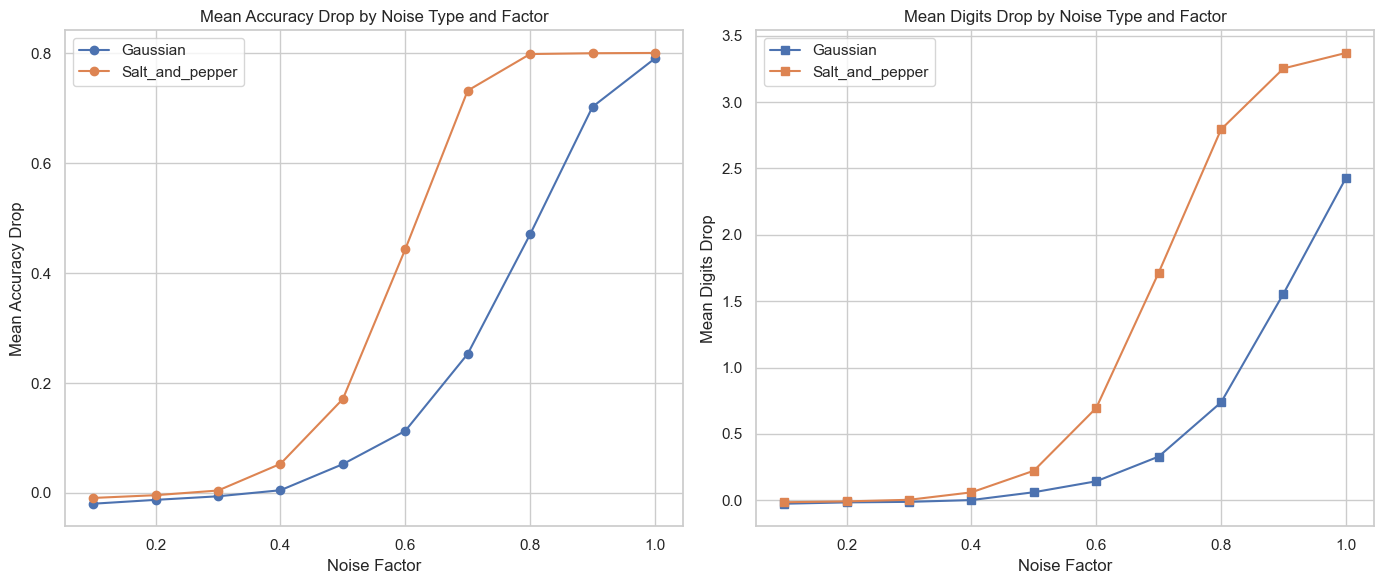

In [16]:
# Filter clean data (noise_factor == 0.0)
clean_df = df[df['noise_factor'] == 0.0][['id', 'correct', 'n_correct_digits']].rename(columns={'correct': 'correct_clean', 'n_correct_digits': 'n_correct_clean'})

# Merge with noisy data
noisy_df = df[df['noise_factor'] > 0.0][['id', 'noise_type', 'noise_factor', 'correct', 'n_correct_digits']]

# Compute degradation for each CAPTCHA and noise type
degradation_df = pd.merge(noisy_df, clean_df, on='id', how='left')
degradation_df['accuracy_drop'] = degradation_df['correct_clean'] - degradation_df['correct']  # Drop in global accuracy (0-1 scale)
degradation_df['digits_drop'] = degradation_df['n_correct_clean'] - degradation_df['n_correct_digits']  # Drop in avg correct digits

# Descriptive statistics by noise type
print("=== Performance Degradation by Noise Type ===")
degradation_stats = degradation_df.groupby('noise_type').agg({
    'accuracy_drop': ['mean', 'std'],
    'digits_drop': ['mean', 'std']
}).reset_index()
degradation_stats.columns = ['noise_type', 'accuracy_drop_mean', 'accuracy_drop_std', 'digits_drop_mean', 'digits_drop_std']
print(degradation_stats)

# Visualization: Mean degradation by noise type and factor
import matplotlib.pyplot as plt
degradation_by_factor = degradation_df.groupby(['noise_type', 'noise_factor']).agg({
    'accuracy_drop': 'mean',
    'digits_drop': 'mean'
}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for noise_type in ['gaussian', 'salt_and_pepper']:
    subset = degradation_by_factor[degradation_by_factor['noise_type'] == noise_type]
    ax[0].plot(subset['noise_factor'], subset['accuracy_drop'], marker='o', label=f'{noise_type.capitalize()}')
    ax[1].plot(subset['noise_factor'], subset['digits_drop'], marker='s', label=f'{noise_type.capitalize()}')

ax[0].set_xlabel('Noise Factor')
ax[0].set_ylabel('Mean Accuracy Drop')
ax[0].set_title('Mean Accuracy Drop by Noise Type and Factor')
ax[0].legend()
ax[0].grid(True)

ax[1].set_xlabel('Noise Factor')
ax[1].set_ylabel('Mean Digits Drop')
ax[1].set_title('Mean Digits Drop by Noise Type and Factor')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

### 3.4. Performance Comparison between the CNN Model and the OCR API

In this section, we compare the performance of our specialized multi-head CNN model against the general-purpose OCR.space API using the evaluation dataset created in section 3.2. The goal is to quantify the robustness gap between a domain-specific model (trained on CAPTCHA data) and a generic OCR tool, particularly under noise conditions.

Key comparisons include:
- **Global Accuracy**: Percentage of CAPTCHAs where all 4 digits are correctly predicted by each model.
- **Average Accuracy per Digit**: Mean accuracy across the 4 positions for the CNN model, with OCR accuracy treated as a single prediction (since OCR returns a string).
- **Performance by Noise Level**: Trends in accuracy as noise intensity increases, highlighting where the CNN outperforms the OCR API.
- **Comparison by Noise Type**: Differences in resilience between Gaussian and Salt & Pepper noise for both models.

We leverage the existing DataFrame (`df`) for these analyses, focusing on rows where OCR predictions are available.

=== Global Performance Comparison ===
CNN Global Accuracy (all 4 digits correct): 50.87%
CNN Average Correct Digits per CAPTCHA: 2.96/4
OCR Global Accuracy: 50.00%
CNN Accuracy per Digit:
  Digit 1: 75.79%
  Digit 2: 71.44%
  Digit 3: 73.17%
  Digit 4: 75.16%


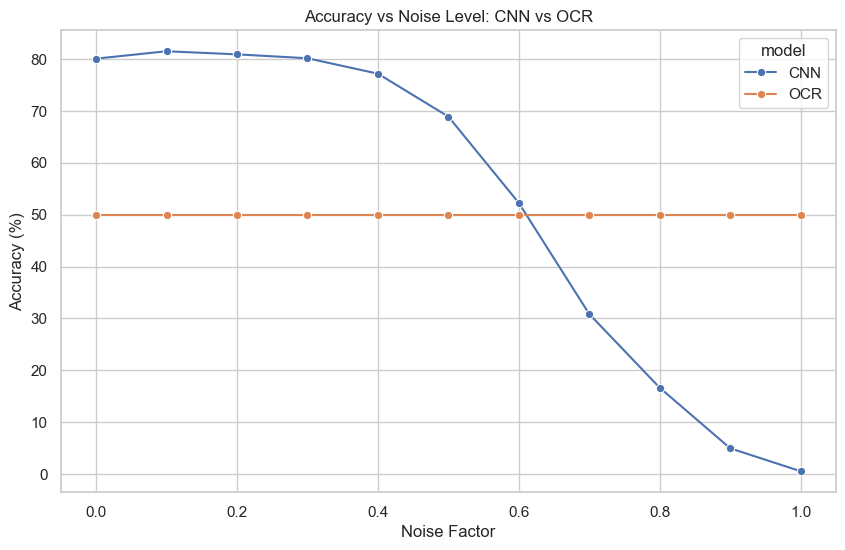

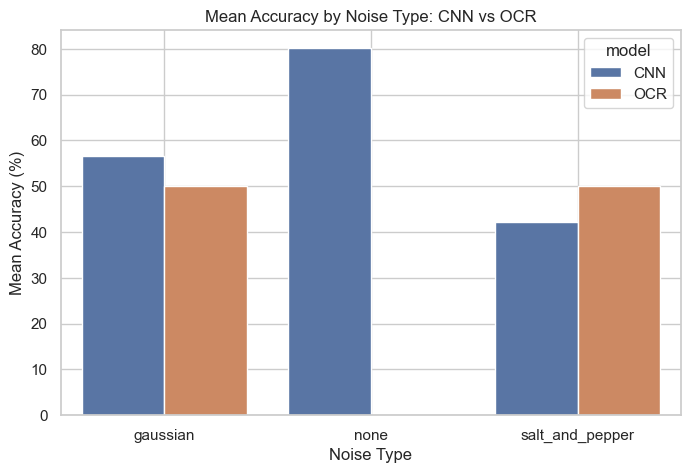


=== Summary Statistics ===
OCR evaluated on 210 CAPTCHAs with predictions.
CNN outperforms OCR by 0.87% in global accuracy.


In [17]:
# df should already be in memory; otherwise, reload from CSV
# df = pd.read_csv('data/captcha_evaluation.csv')  # Uncomment if necessary

# Filter to data with OCR predictions (non-NaN)
df_ocr = df.dropna(subset=['OCR_response']).copy()

# Clean OCR responses (remove spaces, non-digits, limit to 4 chars)
df_ocr['OCR_response_clean'] = df_ocr['OCR_response'].str.replace(r'\D', '', regex=True).str[:4]

# Evaluate OCR accuracy
df_ocr['ocr_correct'] = df_ocr.apply(
    lambda row: int(row['solution'] == row['OCR_response_clean']),
    axis=1
)

# 1. Global descriptive statistics comparison
print("=== Global Performance Comparison ===")
try:
    cnn_global_accuracy = global_accuracy
    cnn_avg_correct_digits = avg_correct_digits
    print(f"CNN Global Accuracy (all 4 digits correct): {cnn_global_accuracy:.2f}%")
    print(f"CNN Average Correct Digits per CAPTCHA: {cnn_avg_correct_digits:.2f}/4")
except NameError:
    print("Error: Please run the cells in section 3.3 to compute global_accuracy and avg_correct_digits.")

ocr_global_accuracy = df_ocr['ocr_correct'].mean() * 100
print(f"OCR Global Accuracy: {ocr_global_accuracy:.2f}%")

# Accuracy per digit for CNN (reused)
try:
    print("CNN Accuracy per Digit:")
    for i, acc in enumerate(digit_accuracies):
        print(f"  Digit {i+1}: {acc:.2f}%")
except NameError:
    print("Error: Please run the cells in section 3.3 to compute digit_accuracies.")

# 2. Performance by noise level comparison
try:
    cnn_noise_performance = noise_performance.copy()
    cnn_noise_performance['model'] = 'CNN'
    cnn_noise_performance = cnn_noise_performance.rename(columns={'correct': 'accuracy'})
except NameError:
    print("Error: Please run the cells in section 3.3 to compute noise_performance.")
    cnn_noise_performance = pd.DataFrame()

ocr_noise_performance = df_ocr.groupby('noise_factor').agg({'ocr_correct': 'mean'}).reset_index()
ocr_noise_performance['ocr_correct'] *= 100
ocr_noise_performance['model'] = 'OCR'
ocr_noise_performance = ocr_noise_performance.rename(columns={'ocr_correct': 'accuracy'})

if not cnn_noise_performance.empty:
    combined_noise = pd.concat([cnn_noise_performance[['noise_factor', 'accuracy', 'model']], ocr_noise_performance])
    
    # Visualization: Accuracy vs Noise Level
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=combined_noise, x='noise_factor', y='accuracy', hue='model', marker='o', ax=ax)
    ax.set_xlabel('Noise Factor')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy vs Noise Level: CNN vs OCR')
    ax.grid(True)
    plt.show()

# 3. Comparison by noise type
try:
    cnn_noise_type = summary.reset_index()
    cnn_noise_type['model'] = 'CNN'
    cnn_noise_type = cnn_noise_type.rename(columns={'correct_mean': 'accuracy_mean', 'correct_std': 'accuracy_std'})
except NameError:
    print("Error: Please run the cells in section 3.3 to compute summary.")
    cnn_noise_type = pd.DataFrame()

ocr_noise_type = df_ocr[df_ocr['noise'] == 1].groupby('noise_type').agg({'ocr_correct': ['mean', 'std']})
ocr_noise_type.columns = ['accuracy_mean', 'accuracy_std']
ocr_noise_type['accuracy_mean'] *= 100
ocr_noise_type['accuracy_std'] *= 100
ocr_noise_type = ocr_noise_type.reset_index()
ocr_noise_type['model'] = 'OCR'

if not cnn_noise_type.empty:
    combined_type = pd.concat([cnn_noise_type[['noise_type', 'accuracy_mean', 'model']], ocr_noise_type[['noise_type', 'accuracy_mean', 'model']]])
    
    # Visualization: Accuracy by Noise Type
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=combined_type, x='noise_type', y='accuracy_mean', hue='model', ax=ax)
    ax.set_xlabel('Noise Type')
    ax.set_ylabel('Mean Accuracy (%)')
    ax.set_title('Mean Accuracy by Noise Type: CNN vs OCR')
    ax.grid(True)
    plt.show()

print("\n=== Summary Statistics ===")
print(f"OCR evaluated on {len(df_ocr)} CAPTCHAs with predictions.")
print(f"CNN outperforms OCR by {cnn_global_accuracy - ocr_global_accuracy:.2f}% in global accuracy.")

### 3.5. Identification of the Most Challenging CAPTCHAs to Recognize

In this subsection, we perform descriptive statistics to identify patterns in CAPTCHA recognition difficulties using the evaluation DataFrame (`df`). The goal is to determine which CAPTCHAs are hardest for the multi-head CNN to recognize and derive characteristics of an "optimal" CAPTCHA (one that maximizes errors for security purposes).

Key analyses include:
- **Most Confused Digits**: Frequency of errors per digit position and common misclassifications.
- **Best/Worst Predicted Combinations**: Accuracy by unique digit sequences, highlighting sequences with high/low success rates.
- **Error Visualizations**: Bar plots or histograms for digits with the highest error rates.
- **Impact of Digit Patterns**: Whether repeated digits (e.g., 4 identical digits) or paired patterns (e.g., two pairs of different digits) affect accuracy.
- **Optimal CAPTCHA Characteristics**: Summary statistics to define features that make CAPTCHAs challenging (e.g., low accuracy for certain patterns).

These insights use pre-computed predictions from `df`, focusing on noise-affected data for robustness analysis.

=== 3.5. Identification of the Most Challenging CAPTCHAs to Recognize ===

1. Most Confused Digits:
  Error rate for Digit 1: 24.21%
  Error rate for Digit 2: 28.56%
  Error rate for Digit 3: 26.83%
  Error rate for Digit 4: 24.84%

  Common Misclassifications per Position:
    Position 1 Confusion Matrix (top 3 most confused):
      True 0 -> Predicted 8: 509 times
      True 9 -> Predicted 8: 396 times
      True 6 -> Predicted 8: 394 times
    Position 2 Confusion Matrix (top 3 most confused):
      True 6 -> Predicted 8: 687 times
      True 0 -> Predicted 8: 674 times
      True 4 -> Predicted 8: 488 times
    Position 3 Confusion Matrix (top 3 most confused):
      True 0 -> Predicted 8: 442 times
      True 6 -> Predicted 8: 430 times
      True 9 -> Predicted 8: 415 times
    Position 4 Confusion Matrix (top 3 most confused):
      True 9 -> Predicted 7: 475 times
      True 6 -> Predicted 5: 441 times
      True 8 -> Predicted 5: 336 times

  Full Confusion Matrices per Positi

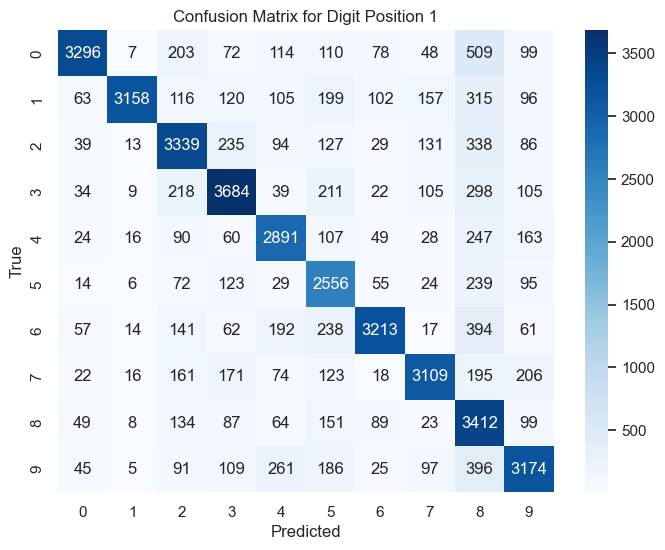

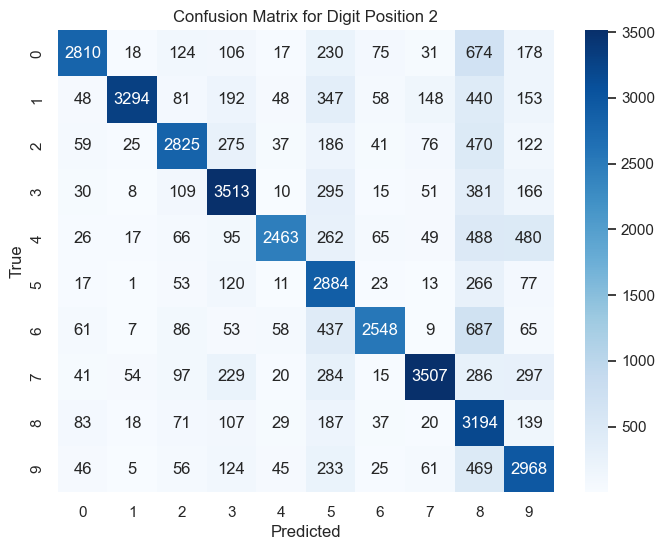

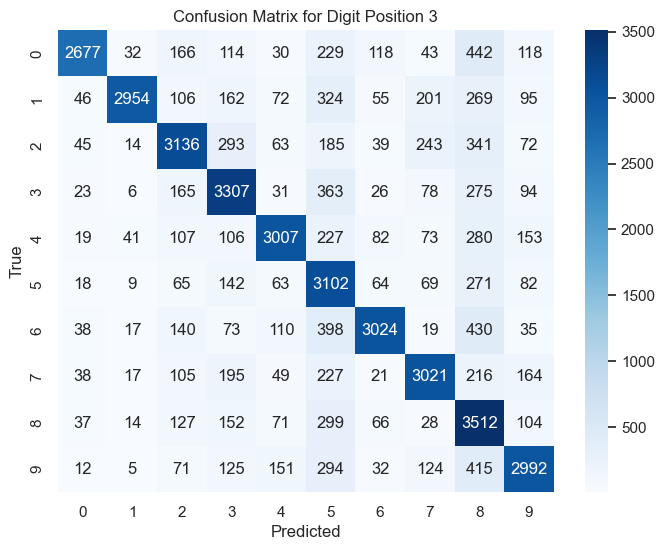

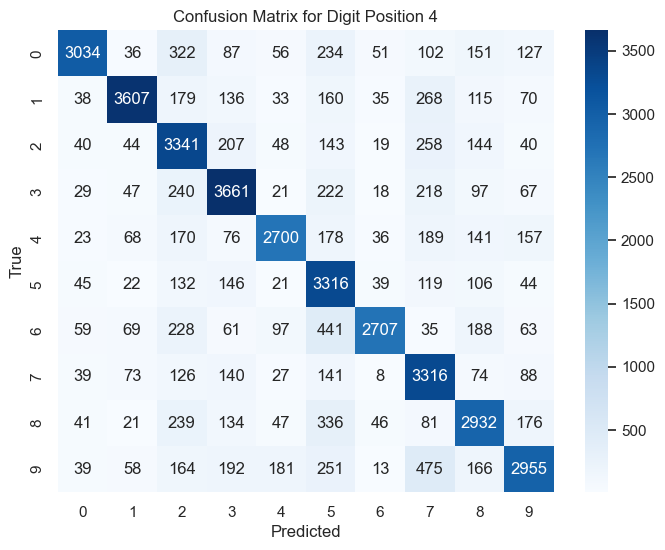


2. Best/Worst Predicted Combinations:
  Top 5 Best Predicted Combinations (highest global accuracy):
    Sequence '7885': 85.71% global accuracy, 94.05% avg correct digits
    Sequence '0346': 80.95% global accuracy, 86.90% avg correct digits
    Sequence '2582': 80.95% global accuracy, 83.33% avg correct digits
    Sequence '2935': 80.95% global accuracy, 84.52% avg correct digits
    Sequence '3253': 80.95% global accuracy, 85.71% avg correct digits

  Top 5 Worst Predicted Combinations (lowest global accuracy):
    Sequence '0323': 0.00% global accuracy, 59.52% avg correct digits
    Sequence '0399': 0.00% global accuracy, 57.14% avg correct digits
    Sequence '0427': 0.00% global accuracy, 59.52% avg correct digits
    Sequence '0661': 0.00% global accuracy, 39.29% avg correct digits
    Sequence '0794': 0.00% global accuracy, 61.90% avg correct digits

3. Error Visualizations:


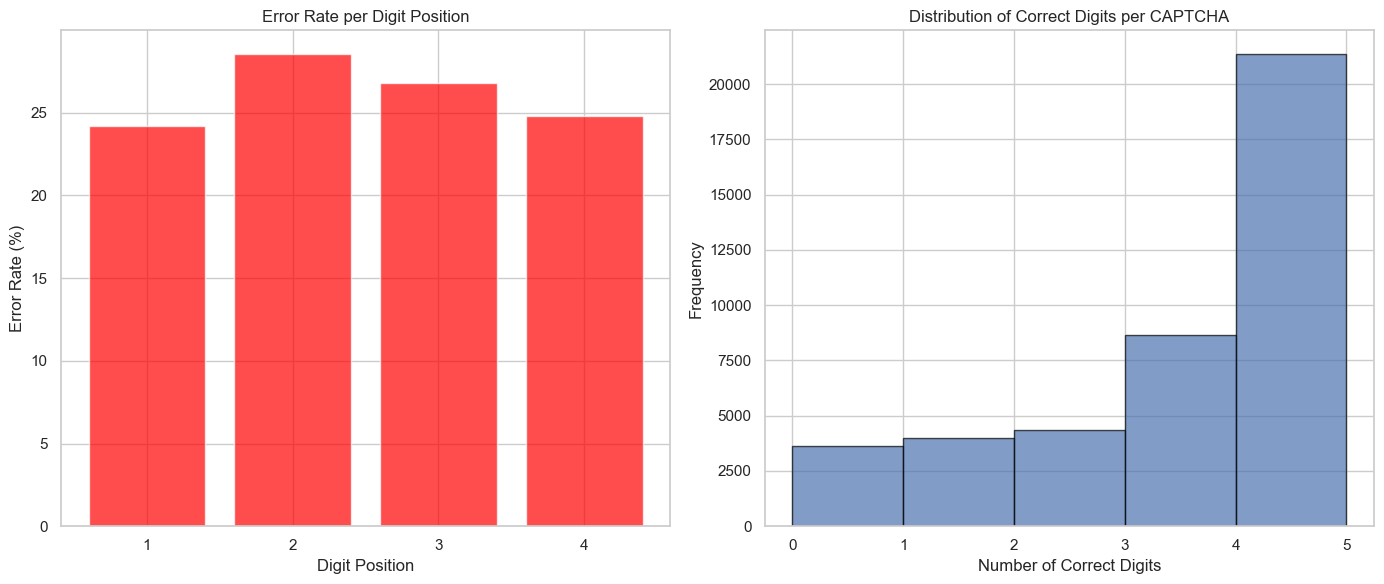


4. Impact of Digit Patterns:
  Accuracy by Pattern Type:
    Other: 51.01% global accuracy, 74.07% avg correct digits
    Has pairs: 50.69% global accuracy, 73.68% avg correct digits
    All digits same: 57.14% global accuracy, 76.19% avg correct digits

  Statistics per Digit (0-9):
    Digit 0: Error rate = 30.36% (errors: 5151, total: 16968)
    Digit 1: Error rate = 28.36% (errors: 5152, total: 18165)
    Digit 2: Error rate = 26.77% (errors: 4621, total: 17262)
    Digit 3: Error rate = 22.56% (errors: 4126, total: 18291)
    Digit 4: Error rate = 28.73% (errors: 4458, total: 15519)
    Digit 5: Error rate = 18.52% (errors: 2695, total: 14553)
    Digit 6: Error rate = 30.90% (errors: 5140, total: 16632)
    Digit 7: Error rate = 23.85% (errors: 4057, total: 17010)
    Digit 8: Error rate = 20.74% (errors: 3414, total: 16464)
    Digit 9: Error rate = 29.45% (errors: 5047, total: 17136)

5. Optimal CAPTCHA Characteristics:
  Characteristics of the Most Challenging CAPTCHAs (based

In [18]:
print("=== 3.5. Identification of the Most Challenging CAPTCHAs to Recognize ===\n")

# 1. Most Confused Digits
print("1. Most Confused Digits:")
error_rates = []
for i in range(4):
    error_rate = (1 - df[f'correct_digit_{i}'].mean()) * 100
    error_rates.append(error_rate)
    print(f"  Error rate for Digit {i+1}: {error_rate:.2f}%")

# Common misclassifications per position
print("\n  Common Misclassifications per Position:")
for i in range(4):
    # Filter errors for this position
    errors = df[df[f'correct_digit_{i}'] == 0]
    if not errors.empty:
        true_digits = errors['solution'].str[i].astype(int)
        pred_digits = errors['model_response'].str[i].astype(int)
        confusion = pd.crosstab(true_digits, pred_digits, rownames=['True'], colnames=['Predicted'])
        print(f"    Position {i+1} Confusion Matrix (top 3 most confused):")
        # Get top 3 most frequent confusions
        flat_conf = confusion.stack().sort_values(ascending=False).head(3)
        for (true, pred), count in flat_conf.items():
            print(f"      True {true} -> Predicted {pred}: {count} times")

# Full Confusion Matrices with Heatmaps
print("\n  Full Confusion Matrices per Position:")
import seaborn as sns
for i in range(4):
    true_digits = df['solution'].str[i].astype(int)
    pred_digits = df['model_response'].str[i].astype(int)
    confusion_full = pd.crosstab(true_digits, pred_digits, rownames=['True'], colnames=['Predicted'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_full, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Confusion Matrix for Digit Position {i+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 2. Best/Worst Predicted Combinations
print("\n2. Best/Worst Predicted Combinations:")
# Group by unique solution (CAPTCHA sequence)
combo_performance = df.groupby('solution').agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
combo_performance['correct'] *= 100
combo_performance['n_correct_digits'] /= 4  # Normalize to [0,1]

# Best combinations (highest accuracy)
best_combos = combo_performance.nlargest(5, 'correct')
print("  Top 5 Best Predicted Combinations (highest global accuracy):")
for _, row in best_combos.iterrows():
    print(f"    Sequence '{row['solution']}': {row['correct']:.2f}% global accuracy, {row['n_correct_digits']*100:.2f}% avg correct digits")

# Worst combinations (lowest accuracy)
worst_combos = combo_performance.nsmallest(5, 'correct')
print("\n  Top 5 Worst Predicted Combinations (lowest global accuracy):")
for _, row in worst_combos.iterrows():
    print(f"    Sequence '{row['solution']}': {row['correct']:.2f}% global accuracy, {row['n_correct_digits']*100:.2f}% avg correct digits")

# 3. Error Visualizations
print("\n3. Error Visualizations:")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for error rates per position
axes[0].bar(range(1, 5), error_rates, color='red', alpha=0.7)
axes[0].set_xlabel('Digit Position')
axes[0].set_ylabel('Error Rate (%)')
axes[0].set_title('Error Rate per Digit Position')
axes[0].set_xticks(range(1, 5))
axes[0].grid(True, axis='y')

# Histogram of n_correct_digits
axes[1].hist(df['n_correct_digits'], bins=range(6), alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Number of Correct Digits')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Correct Digits per CAPTCHA')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

# 4. Impact of Digit Patterns
print("\n4. Impact of Digit Patterns:")
# Analyze patterns: all same digits, pairs, etc.
df_patterns = df.copy()
df_patterns['all_same'] = df_patterns['solution'].apply(lambda x: len(set(x)) == 1)
df_patterns['has_pairs'] = df_patterns['solution'].apply(lambda x: any(x.count(d) == 2 for d in set(x)))
df_patterns['unique_count'] = df_patterns['solution'].apply(lambda x: len(set(x)))

pattern_analysis = df_patterns.groupby(['all_same', 'has_pairs']).agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
pattern_analysis['correct'] *= 100
pattern_analysis['n_correct_digits'] /= 4

print("  Accuracy by Pattern Type:")
for _, row in pattern_analysis.iterrows():
    pattern_desc = []
    if row['all_same']:
        pattern_desc.append("All digits same")
    if row['has_pairs']:
        pattern_desc.append("Has pairs")
    if not pattern_desc:
        pattern_desc.append("Other")
    desc = " & ".join(pattern_desc)
    print(f"    {desc}: {row['correct']:.2f}% global accuracy, {row['n_correct_digits']*100:.2f}% avg correct digits")

# Statistics per Digit (0-9)
print("\n  Statistics per Digit (0-9):")
for digit in range(10):
    # Error rate for each digit across all positions
    digit_errors = 0
    digit_total = 0
    for pos in range(4):
        pos_true = df['solution'].str[pos].astype(int)
        pos_pred = df['model_response'].str[pos].astype(int)
        digit_total += (pos_true == digit).sum()
        digit_errors += ((pos_true == digit) & (pos_pred != digit)).sum()
    if digit_total > 0:
        error_rate_digit = (digit_errors / digit_total) * 100
        print(f"    Digit {digit}: Error rate = {error_rate_digit:.2f}% (errors: {digit_errors}, total: {digit_total})")

# 5. Optimal CAPTCHA Characteristics
print("\n5. Optimal CAPTCHA Characteristics:")

hardest_combos = worst_combos.head(3)  # Top 3 worst
print("  Characteristics of the Most Challenging CAPTCHAs (based on lowest accuracy sequences):")
print(f"    - Sequences with lowest global accuracy: {', '.join(hardest_combos['solution'].tolist())}")
print(f"    - Average global accuracy for these: {hardest_combos['correct'].mean():.2f}%")
print(f"    - Average correct digits: {hardest_combos['n_correct_digits'].mean()*4:.2f}/4")

# Positions with highest error rates
max_error_pos = np.argmax(error_rates) + 1
print(f"    - Most error-prone position: Digit {max_error_pos} (error rate: {error_rates[max_error_pos-1]:.2f}%)")

# Patterns that are hard
hard_patterns = pattern_analysis.nsmallest(1, 'correct')
if not hard_patterns.empty:
    row = hard_patterns.iloc[0]
    pattern_desc = []
    if row['all_same']:
        pattern_desc.append("all digits identical")
    if row['has_pairs']:
        pattern_desc.append("containing pairs")
    if not pattern_desc:
        pattern_desc.append("other patterns")
    desc = " and ".join(pattern_desc)
    print(f"    - Hardest pattern: Sequences with {desc} (accuracy: {row['correct']:.2f}%)")

print("\n  Summary: Optimal CAPTCHAs for security should feature sequences like those above, with high error rates in specific positions and patterns that confuse the model.")